In [30]:
import pandas as pd
import glob
import numpy as numpy
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
import time
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
import seaborn as sns
import holidays
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# from nn_train import do_job


# cna not import into global namespace  for multiprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, BatchNormalization, TimeDistributed, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.constraints import max_norm

from multiprocessing import Process, Pool

import os
import multiprocessing as mp
import warnings
from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise

warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [31]:
EARLIEST_DATE = '2012-01-01'
N_COMPONENTS=100

# REad in data

In [34]:

def read_in_data(check_recent_date=True, recent_date_check=datetime.datetime.now().date()):
    dict_of_stocks_and_dfs = {}
    for file_ in glob.glob('../data/updated_historical_stock_and_etf_data/*.csv'):
        stock_name = file_.rsplit("/")[-1].split('_')[0].lower() 
        print(f"Reading in {stock_name}")
        df_  = pd.read_csv(f"{file_}")
        # ensure we have the most recent data
        most_recent_date = pd.to_datetime(df_.date.max())
        oldest_date = pd.to_datetime(df_.date.min())
        
        oldest_date_bool = oldest_date < datetime.datetime(2014,1,1).date()
        recent_date_bool = most_recent_date == recent_date_check
        
        if oldest_date_bool and recent_date_bool:
            dict_of_stocks_and_dfs[stock_name] = df_.sort_values('date')
        elif oldest_date_bool and not check_recent_date:
            dict_of_stocks_and_dfs[stock_name] = df_.sort_values('date')            
        else:
            print(f"Stock {stock_name} most recent date is {most_recent_date} oldest date is {oldest_date}. Skipping it")
    return dict_of_stocks_and_dfs

In [35]:
dict_of_stocks_and_dfs = read_in_data(recent_date_check=datetime.datetime(2020,5,22).date())

Reading in lb
Reading in lind
Reading in wal
Stock wal most recent date is 2020-05-15 00:00:00 oldest date is 2005-06-29 00:00:00. Skipping it
Reading in doyu
Stock doyu most recent date is 2020-05-22 00:00:00 oldest date is 2019-07-17 00:00:00. Skipping it
Reading in fsbw
Stock fsbw most recent date is 2020-05-15 00:00:00 oldest date is 2012-07-10 00:00:00. Skipping it
Reading in pfbc
Stock pfbc most recent date is 2020-05-15 00:00:00 oldest date is 2011-07-21 00:00:00. Skipping it
Reading in pg
Reading in hasi
Stock hasi most recent date is 2020-05-15 00:00:00 oldest date is 2013-04-18 00:00:00. Skipping it
Reading in mtb
Stock mtb most recent date is 2020-05-15 00:00:00 oldest date is 1991-10-04 00:00:00. Skipping it
Reading in mtn
Reading in rbb
Stock rbb most recent date is 2020-05-15 00:00:00 oldest date is 2017-07-26 00:00:00. Skipping it
Reading in are
Reading in gden
Reading in lvs
Reading in jpm
Stock jpm most recent date is 2020-05-15 00:00:00 oldest date is 1970-01-02 00:00

In [36]:
(len(dict_of_stocks_and_dfs.keys())-1) * len(dict_of_stocks_and_dfs.keys())

1122

In [38]:
len(dict_of_stocks_and_dfs.keys())

34

# Create correlation features

In [39]:
def build_correlation_dfs(dict_of_stocks_and_dfs, n_day_rolling_features_list=[ 3,5, 7, 10, 30, 180, 365], verbose=False):
    """
    Create correlation + variance based  upon daily closing stock prices for given date ranges
    
    also include daily volume
    
    We are trying to  predict 7 day correaltion
    """

    stock_features_dict = defaultdict(pd.DataFrame)
    start_time = time.time()
    
    start = time.time()
    n_stocks = len(dict_of_stocks_and_dfs.keys())
    final_feature_df = create_date_dummy_df()
    pairs_of_stocks = []
    
    for idx, first_stock_name in enumerate(dict_of_stocks_and_dfs.keys()):
        print('')
        print(f"Finished {idx/n_stocks} pct of stocks")
        print('')
        for second_idx, second_stock_name in enumerate(dict_of_stocks_and_dfs.keys()):
            stock_pair = f"{first_stock_name}_{second_stock_name}"
            reverse_pair = f"{second_stock_name}_{first_stock_name}"
            
            if (first_stock_name == second_stock_name) or (stock_pair in pairs_of_stocks)  or (reverse_pair in pairs_of_stocks): # pnr -> ual same as ual -> pnr
                continue
            else:
                pairs_of_stocks.append(stock_pair)
            if verbose:
                print('-------')
                print(f"{first_stock_name} & {second_stock_name}")
                print('-------')
            
            # here the date is not the index, yet
            first_stock_df = dict_of_stocks_and_dfs[f"{first_stock_name}"].loc[ 
                dict_of_stocks_and_dfs[f"{first_stock_name}"].date.isin(dict_of_stocks_and_dfs[f"{second_stock_name}"].date), :]

            #  filter second df by the dates in first

            # here the date is not the index, yet
            second_stock_df = dict_of_stocks_and_dfs[f"{second_stock_name}"].loc[ 
                dict_of_stocks_and_dfs[f"{second_stock_name}"].date.isin(first_stock_df.date), :]
            
            # set the date as an index and sort by date
            first_stock_df = first_stock_df.sort_values('date')
            second_stock_df = second_stock_df.sort_values('date')

            first_stock_df = first_stock_df.set_index('date')
            second_stock_df = second_stock_df.set_index('date')
            
            all_features_df = pd.DataFrame()
            for rolling_idx, rolling_day in enumerate(n_day_rolling_features_list):
                if verbose:
                    print(f"Rolling calculations for {rolling_day}")
                features_df = create_correlation_and_variance_features(
                    first_stock_df, second_stock_df, rolling_day, final_feature_df, 
                    first_stock_name=first_stock_name, second_stock_name=second_stock_name)
                   
                current_feature_cols = set(features_df.columns)
                final_feature_cols = set(final_feature_df.columns)

                
                if (f"{first_stock_name}_volume" not in final_feature_df.columns) and (rolling_idx == 0):
                    features_df[f"{first_stock_name}_volume"] = list(first_stock_df.volume)
                
                if (f"{second_stock_name}_volume" not in final_feature_df.columns) and (rolling_idx == 0):
                    features_df[f"{second_stock_name}_volume"] = list(second_stock_df.volume)
                    
                if rolling_idx == 0: 
                    all_features_df = features_df
                else:
                    all_features_df = all_features_df.join(features_df, on='date', lsuffix='_left')
            

                    
            all_features_df.index = pd.to_datetime(all_features_df.index)
            final_feature_df = final_feature_df.join(all_features_df, on='date')

            if verbose:
                end = time.time()
                print(f"Building all features took {(end-start)/60} minutes")
                start = time.time()

    end_time = time.time()
    print(f"Total time {(end_time-start_time) / 60} minutes for {len(pairs_of_stocks)} pairs")
    final_feature_df = add_time_feature(final_feature_df)
    return final_feature_df, pairs_of_stocks
            
        

# Note: will eventuall need to add in 0s for stocks withour correlation data with other stocks due to date range

In [40]:
def create_date_dummy_df(start_date=datetime.datetime(1980,1,1), n_years=50):
    
    #  create dummy df with dates to join against
    list_of_dates  = []
    n_days = 365*n_years
    start_date = start_date

    for i in range(n_days):
        list_of_dates.append(start_date + datetime.timedelta(i))
    df_ = pd.DataFrame(list_of_dates, columns=['date'])
    
    df_.date_ =  pd.to_datetime(df_.date)
    return df_.set_index('date')
    

In [41]:
def add_time_feature(final_stock_df):
    
    days = [i.day for i in final_stock_df.index]
    months = [i.month for i in final_stock_df.index]
    quarters = [i.quarter for i in final_stock_df.index]
    years = [i.year for i in final_stock_df.index]
    
    us_holidays = holidays.UnitedStates()
    
    h_ = np.array([i in us_holidays for i in final_stock_df.index]).astype(int)


    final_stock_df['day'] = days
    final_stock_df['month'] = months
    final_stock_df['quarter'] = quarters
    final_stock_df['year'] = years
#     final_stock_df['is_holiday'] = h_
    
    return final_stock_df

In [42]:
def create_correlation_and_variance_features(first_stock_df, second_stock_df, n_days_stride, final_stock_df, 
                                             first_stock_name=None, second_stock_name=None, verbose=False):
    """
    n_days_stride: the  number of rolling days to calculate correlation for
    """
    n_rows = len(first_stock_df)

    previous_row = 0

    features_per_time_period = defaultdict(list)
    if verbose:
        print(f"Creating correlations + variance on close for {n_days_stride} days")
    
    rolling_close_df = pd.DataFrame(first_stock_df.close.rolling(
        n_days_stride).corr(second_stock_df.close)).rename(
        {'close': f"{first_stock_name}_{second_stock_name}_close_corr_rolling_{n_days_stride}_days"},axis=1).fillna(method='backfill').round(6)

    
    # add cols
    
    current_feature_cols = list(final_stock_df.columns)
    

    # as we go through different pairs will have multiple var / corr for the first stock
    # pnc_bar calcualtes corr for pnr
    #pnr_bat calculates corr for pnr
    # don't want the same cols
    if f"{first_stock_name}_close_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        
        rolling_close_std_first_stock =  first_stock_df.close.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{first_stock_name}_close_std_rolling_{n_days_stride}_days"] = rolling_close_std_first_stock
        
    if f"{second_stock_name}_close_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_close_std_second_stock =  second_stock_df.close.rolling(n_days_stride).std().fillna(method='backfill').round( 6)
        rolling_close_df[f"{second_stock_name}_close_std_rolling_{n_days_stride}_days"] = rolling_close_std_second_stock
        
    if f"{first_stock_name}_volume_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_volume_std_first_stock =  first_stock_df.volume.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{first_stock_name}_volume_std_rolling_{n_days_stride}_days"] = rolling_volume_std_first_stock
        
    if f"{second_stock_name}_volume_std_rolling_{n_days_stride}_days" not in current_feature_cols:
        rolling_volume_std_second_stock =  second_stock_df.volume.rolling(n_days_stride).std().fillna(method='backfill').round(6)
        rolling_close_df[f"{second_stock_name}_volume_std_rolling_{n_days_stride}_days"] = rolling_volume_std_second_stock
    
    return rolling_close_df



In [43]:
# 2 minutes fo 210 pairs
final_stock_df, pairs_of_stocks = build_correlation_dfs(dict_of_stocks_and_dfs, verbose=False)


Finished 0.0 pct of stocks


Finished 0.029411764705882353 pct of stocks


Finished 0.058823529411764705 pct of stocks


Finished 0.08823529411764706 pct of stocks


Finished 0.11764705882352941 pct of stocks


Finished 0.14705882352941177 pct of stocks


Finished 0.17647058823529413 pct of stocks


Finished 0.20588235294117646 pct of stocks


Finished 0.23529411764705882 pct of stocks


Finished 0.2647058823529412 pct of stocks


Finished 0.29411764705882354 pct of stocks


Finished 0.3235294117647059 pct of stocks


Finished 0.35294117647058826 pct of stocks


Finished 0.38235294117647056 pct of stocks


Finished 0.4117647058823529 pct of stocks


Finished 0.4411764705882353 pct of stocks


Finished 0.47058823529411764 pct of stocks


Finished 0.5 pct of stocks


Finished 0.5294117647058824 pct of stocks


Finished 0.5588235294117647 pct of stocks


Finished 0.5882352941176471 pct of stocks


Finished 0.6176470588235294 pct of stocks


Finished 0.6470588235294118 pct of stocks


Fin

In [182]:
# max number of stocks is ~300 NOT 990

In [183]:
len(final_stock_df.columns)

4441

In [184]:
len(final_stock_df.columns)

4441

# Prep code for NN

In [185]:
# prepare the data for LSTM model
def split_sequences(sequences, n_steps, y_col='pg_so_close_corr_rolling_7_days', 
                    start_idx=0, n_val=50, print_idx=100, input_verbose=1,     n_pca_components=100): #2200
    """
    sequences = input_data
    n_steps = n_days of data to give at a time
    
    only works for the currently set y_col
    """
    if y_col not in sequences.columns:
        raise ValueError('This y col does not exist in this df')
    
    X, y = list(), list()
    X_val, y_val = list(), list()
    
    n_sequences = len(sequences)
    print('n_sequences', n_sequences)

    for i in range(start_idx, n_sequences):
        if i == start_idx and input_verbose == 1:
            print(f"Training idx start at {i}")
        if (i % print_idx == 0) and (i != 0) and input_verbose==1:
            print(f"Pct finished = {i/n_sequences}")
            
        # find the end of this pattern
        end_ix = i + n_steps 
        total_end_ix = end_ix + n_val
        # check if we are beyond the dataset
        if (total_end_ix) > n_sequences:
            print(f"Training idx end at {end_ix}")
            print('Total idx checked', total_end_ix)
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = np.array(sequences.loc[:, sequences.columns != f"{y_col}"][i:end_ix]), np.array(
            sequences.loc[:, sequences.columns == f"{y_col}"].shift(-7).fillna(method='ffill').iloc[end_ix-1])

                                 
        X.append(seq_x)
        y.append(seq_y)
    
    val_start_idx = start_idx + n_sequences - (start_idx  + n_val -2)
    for i in range(val_start_idx, n_sequences):
        if i == val_start_idx and input_verbose==1:
            print(f"Val idx start at {val_start_idx}")
        if (i % print_idx == 0) and i != 0 and input_verbose==1:
            print(f"Pct finished for val sequences = {i/n_sequences}")
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences) and input_verbose==1:
            print(f"Val idx end at {end_ix}")
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = np.array(sequences.loc[:, sequences.columns != f"{y_col}"][i:end_ix]), np.array(
            sequences.loc[:, sequences.columns == f"{y_col}"].shift(-7).fillna(method='ffill').iloc[end_ix-1])
        
        
        X_val.append(seq_x)
        y_val.append(seq_y)
    
    

    X, y, X_val, y_val = array(X), array(y), array(X_val), array(y_val)
    
    # errors for standard scaler
    X = np.nan_to_num(X.astype(np.float32)) # converting to float 32 throws some infinity errors
    X_val = np.nan_to_num(X_val.astype(np.float32)) # converting to float 32 throws some infinity errors  
    
    
    scalers = {}
    for i in range(X.shape[1]):
        scalers[i] = StandardScaler()
        X[:, i, :] = scalers[i].fit_transform(X[:, i, :]) 
    X = np.nan_to_num(X.astype(np.float32)) # converting to float 32 throws some infinity errors
    
    pca_scalers = {}

    new_X = np.zeros((X.shape[0], X.shape[1], n_pca_components))
    for i in range(X.shape[1]):
        pca_scalers[i] = PCA(n_components=n_pca_components) # ~80%
        new_X[:, i, :] = pca_scalers[i].fit_transform(X[:, i, :]) 


    for i in range(X_val.shape[1]):
        X_val[:, i, :] = scalers[i].transform(X_val[:, i, :]) 

    X_val = np.nan_to_num(X_val.astype(np.float32)) # converting to float 32 throws some infinity errors  

    new_X_val = np.zeros((X_val.shape[0], X_val.shape[1], n_pca_components))
    for i in range(X_val.shape[1]):
        new_X_val[:, i, :] = pca_scalers[i].transform(X_val[:, i, :]) 
        
   # need  to do this again as standard scaler may have nans
    X = np.nan_to_num(X.astype(np.float32)) # converting to float 32 throws some infinity errors
    X_val = np.nan_to_num(X_val.astype(np.float32)) # converting to float 32 throws some infinity errors 
    print('X val shape', X_val.shape)
    

    
    return new_X, y, new_X_val, y_val, scalers, pca_scalers

    
    

In [213]:
X,y, X_val, y_val, scalers, pca_scalers = split_sequences(
    final_stock_df,
    30, start_idx=0, input_verbose=0,
    n_val=40, y_col=f"lb_lind_close_corr_rolling_7_days"
) # 30 steps

n_sequences 1438
Training idx end at 1399
Total idx checked 1439


IndexError: single positional indexer is out-of-bounds

In [144]:
def build_keras_model(n_steps, n_features, n_units=100, dropout_pct=0.02, n_layers = 1):
    model = Sequential()


    # define CNN model
#     model.add(TimeDistributed(Conv2D(n_units, kernel_and_pool_size))
#     model.add(TimeDistributed(MaxPooling2D(pool_size=kernel_and_pool_size))
#     model.add(TimeDistributed(Flatten()))

        
    model.add(LSTM(n_units, activation='relu', dropout=dropout_pct, return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(BatchNormalization())
    for _ in range(n_layers):
        model.add(LSTM(n_units, activation='relu', dropout=dropout_pct, return_sequences=True))
        model.add(BatchNormalization())
    model.add(LSTM(n_units, activation='relu', dropout=dropout_pct))
    model.add(BatchNormalization())
    model.add(Dense(n_units))
    model.add(Dense(int(n_units/2)))
    model.add(Dense(1))
    #Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
    #LR = 0.0001
    #clipnorm=1., clipvalue=0.5
    model.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False), loss='mse', metrics=['mse'])
    return model

# Train a model

In [245]:
np.sqrt(.4)

0.6324555320336759

In [238]:
# train on all data
# predict for the upcoming week

# 
def prediction_for_upcoming_week(final_stock_df,pairs_of_stocks,  job_id=None, print_idx=1, n_day_sequences=14, 
                                 start_date_training_data='2009-01-01', n_validation_sequences=60, input_batch_size=128, 
                                 input_verbose=0, min_val_mse_threshold=0.40):
    """
    The main entrypoint for training an LSTM network on stock predictions
    
    :param final_stock_df: The list of stock pairs with correlations over different time ranges, volume
    :para pairs_of_stocks: The list of stock pairs
    :param print_idx: The number of iterations to pass before printing out progress
    :param n_day_sequences: The number of sequences to pass to the LSTM (i.e. the number of days)
    :param start_date_training_data: Filter for data before thie date to train on
    :param n_validation_sequences: Number of sequences to validate on. Should be >= 50
    :param input_batch_size: size of the batches for training NN
    :parm input_verbose: if 1, print out everything otherwise, don't
    :param min_val_mse_threshold: the minimum val mse in order to consider these stocks predictions for the upcoming week. 
    """

    # validation needs to be 40 or index error
    final_stock_df = final_stock_df.dropna()
    final_stock_df = final_stock_df.sort_values(by='date')
    # add this to predictions
    stock_to_industry = pd.read_csv('../data/Industries stock list - all.csv')
    stock_to_industry.symbol = [i.lower() for i in stock_to_industry.symbol]

    final_stock_df = final_stock_df.dropna()
    most_recent_date = final_stock_df.index.max()

    prediction_end = most_recent_date + datetime.timedelta(7)



    test_df = final_stock_df.iloc[-n_day_sequences:, :]

    

    n_days_corr_predictions = 7


    pct_change_corr = []
    predicted_corr = []
    last_corr_for_prediction_day = []
    pred_dates = []
    first_stock_industries = []
    second_stock_industries = []
    
    first_model = True

    start_final_time = time.time()
    total_n = len(pairs_of_stocks)
    
    for idx,stock_pairing in enumerate(pairs_of_stocks):
        if idx % print_idx == 0 and input_verbose ==1 :
            print('----------')
            print(f"Stock pairing = {stock_pairing}")
            print(f"Pct finished = {idx/total_n}")
        first_stock_name, second_stock_name = stock_pairing.split('_')

        first_stock_industries.append(stock_to_industry[stock_to_industry.symbol == first_stock_name].industry.values[0])
        second_stock_industries.append(stock_to_industry[stock_to_industry.symbol == second_stock_name].industry.values[0])



        pred_col_name = f"{stock_pairing}_close_corr_rolling_{n_days_corr_predictions}_days"
        print('pred_col_name', pred_col_name)

        # remove the current 7-day corr for this stock
        # for 7 take rolling 7 days corr to the present day to predict off of
        
        ## TRAINING AND TESTING DATA
        X,y, X_val, y_val, scalers, pca_scalers = split_sequences(
            final_stock_df[final_stock_df.index  >= f"{start_date_training_data}"],
            n_day_sequences, start_idx=0, input_verbose=1,
            n_val=n_validation_sequences, y_col=f"{pred_col_name}"
        ) # 30 steps
        
        train_X, train_y = final_stock_df.loc[:, final_stock_df.columns != f"{pred_col_name}"],  final_stock_df[f"{pred_col_name}"].shift(-7).fillna(method='ffill') 
                                                           # get corr from 7 days in the future
        test_X, test_y = np.array(test_df.loc[:, test_df.columns != f"{pred_col_name}"]),  test_df[f"{pred_col_name}"]
        test_X = test_X.reshape(1, test_X.shape[0], test_X.shape[1])
        test_X = np.nan_to_num(test_X.astype(np.float32))
        
        for i in range(test_X.shape[1]):
            test_X[:, i, :] = scalers[i].transform(test_X[:, i, :]) 
        test_X = np.nan_to_num(test_X.astype(np.float32))
        
        new_X_test = np.zeros((test_X.shape[0], test_X.shape[1], N_COMPONENTS))
        for i in range(test_X.shape[1]):
            new_X_test[:, i, :] = pca_scalers[i].transform(test_X[:, i, :]) 
        

        
#         return X,y, X_val, y_val, new_X_test
        ## END TRAINING AND TESTING DATA 
        
        
        if first_model:
            print('building model')
            smaller_model = build_keras_model(X.shape[1],X.shape[2])
            print(smaller_model.summary())
            
        # test again at 700 epochs
        if first_model:
            start = time.time()
            # 800 epochs
            early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=600, verbose=1, restore_best_weights=True)
            print('starting training')
            history = smaller_model.fit(x=X, y=y, batch_size=input_batch_size, epochs=800, verbose=input_verbose, 
                      validation_data=(X_val, y_val), shuffle=False,  use_multiprocessing=False, callbacks=[early_stopping])
            end=time.time()

            print((end-start)/60,' minutes')
        else:

            # Freeze the layers except the last 5 layers
            for layer in smaller_model.layers[:-3]:
                layer.trainable = False
            # Check the trainable status of the individual layers

            smaller_model.compile(optimizer=Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False), loss='mse', metrics=['mse'])
            
            start = time.time()
            early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, verbose=1, restore_best_weights=True)

            history = smaller_model.fit(x=X, y=y, batch_size=input_batch_size, epochs=200, verbose=input_verbose, 
                      validation_data=(X_val, y_val), shuffle=False,  use_multiprocessing=False, callbacks=[early_stopping])
            end=time.time()
            print((end-start)/60,' minutes')

    
        history_df  = pd.DataFrame(history.history)
        history_df[['mse', 'val_mse']].iloc[-200:, :].plot()
        min_val_mse = np.min(history_df['val_mse'])
        plt.show()
        prediction = smaller_model.predict(new_X_test)[0][0] 

        if idx % print_idx==0:
            print(f"Prediction = {prediction}")



        last_corr_date = train_y.index.max()
        last_corr = train_y[train_y.index.max()]  
        if idx % print_idx==0:
            print(f"Last corr = {last_corr}")
        
        if min_val_mse <= min_val_mse_threshold:
            pred_dates.append(most_recent_date)
            predicted_corr.append(prediction)
            last_corr_for_prediction_day.append(last_corr)
        else:
            pred_dates.append(most_recent_date)
            predicted_corr.append('too_high_of_mse')
            last_corr_for_prediction_day.append(last_corr)
        
        if input_verbose==1 and idx % print_idx==0:
            print(f"{stock_pairing} corr7-day corr of close from {most_recent_date} to {prediction_end} is {prediction} ")
        
        first_model = False


    end_final_time = time.time()

    print(f"Predictions took {(end_final_time-start_final_time)/60} mins")

    squarred_difference = (np.array(last_corr_for_prediction_day)-np.array(predicted_corr))**2

    prediction_df = pd.DataFrame({ 'pred_date_start':pred_dates,'stock_pair':pairs_of_stocks,   'first_stock_industry': first_stock_industries, 
                   'second_stock_industry': second_stock_industries,
                   'predicted_corr': predicted_corr, 'last_7_day_corr_for_pred_date_start': last_corr_for_prediction_day, 
            'squarred_diff_7_day_cor': (np.array(last_corr_for_prediction_day)-np.array(predicted_corr))**2
                 })
    
    if job_id:
        tmp_filepath = '../data/lstm_tmp_prediction_dfs'
        if not os.path.isdir(f"{tmp_filepath}"):
            os.mkdir(f"{tmp_filepath}")
        prediction_df.to_csv(
        f'{tmp_filepath}/{job_id}_lstm_test_predictions_{most_recent_date}-{prediction_end}.csv', index=False)
    else:
        prediction_df.to_csv(
    f'../data/predictions/lstm_test_predictions_{most_recent_date}-{prediction_end}.csv', index=False)


In [239]:
len(pairs_of_stocks)

561

In [240]:
# def chunks(l, n):
#     return [l[i:i+n] for i in range(0, len(l), n)]



# def dispatch_jobs(data, job_number, pairs):
#     total = len(pairs)
#     chunk_size = total / job_number
#     slice = chunks(pairs, int(chunk_size))
#     jobs = []
#     executor = ProcessPoolExecutor(max_workers=5, mp_context=mp.get_context("spawn"))
#     i = 1
#     pair = slice[0]
#     print(pair)
#     executor.map(do_job, (pair, data, 1))


# #     for i, pair in enumerate(slice):
# #         print(i)
        
# #         j = Process(target=do_job, args=(i, pair, data))
# #         jobs.append(j)
        

# #         executor.map(do_job, (i, pair, data))


        
# #         executor.submit(do_job)
# #     for j in jobs:
# #         j.start()
        
# # def main():
# #     executor = ProcessPoolExecutor(mp_context=mp.get_context("spawn"), max_workers=5)
# #     task1 = executor.submit(task)
# #     task2 = executor.submit(task)acorr

In [241]:
# from concurrent.futures import ProcessPoolExecutor
# import multiprocessing as mp

# # # from external import just_print

# executor = ProcessPoolExecutor(mp_context=mp.get_context("spawn"), max_workers=5)


# if __name__ == '__main__':
#     num_workers=3
# #     dispatch_jobs(final_stock_df, num_workers , pairs_of_stocks[:100])
    
#     executor = ProcessPoolExecutor(max_workers=5, mp_context=mp.get_context("spawn"))
#     i = 1


#     executor.map(do_job, (pairs_of_stocks[:10], final_stock_df, 1))

In [242]:
# if __name__ == '__main__':
#     mp.set_start_method('spawn', force=True)
#     final_stock_df = final_stock_df.dropna()
#     num_workers = mp.cpu_count()  
#     num_workers=2
#     dispatch_jobs(final_stock_df, num_workers , pairs_of_stocks[:100])

pred_col_name lb_lind_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
building model
Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_51 (LSTM)               (None, 14, 100)           80400     
____________________________________________________________

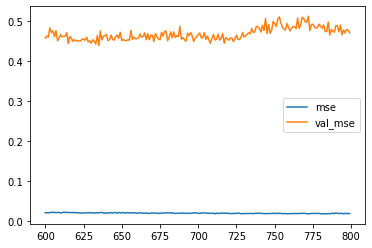

Prediction = 0.03330913931131363
Last corr = -0.878309
pred_col_name lb_pg_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

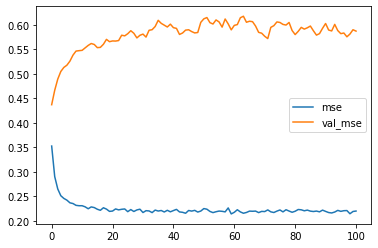

Prediction = 0.051460664719343185
Last corr = -0.961612
pred_col_name lb_mtn_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

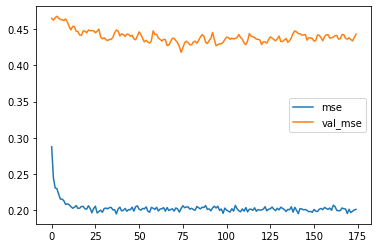

Prediction = 0.06817387044429779
Last corr = -0.886174
pred_col_name lb_are_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

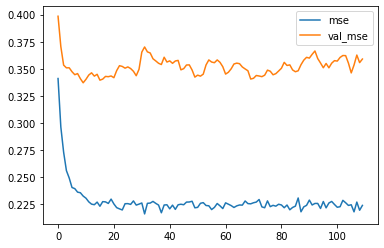

Prediction = 0.21654778718948364
Last corr = -0.891705
pred_col_name lb_gden_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

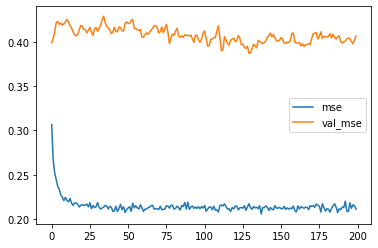

Prediction = 0.2821102440357208
Last corr = -0.632421
pred_col_name lb_lvs_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

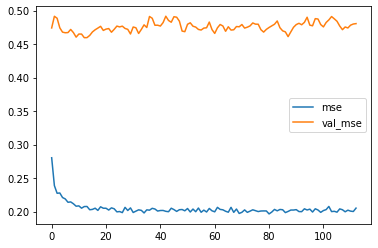

Prediction = 0.2692687213420868
Last corr = -0.916923
pred_col_name lb_fun_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

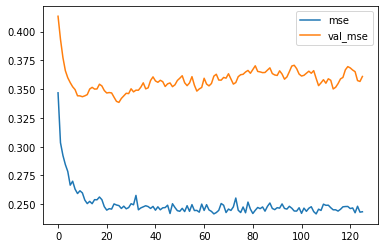

Prediction = -0.07217434793710709
Last corr = -0.738012
pred_col_name lb_rop_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

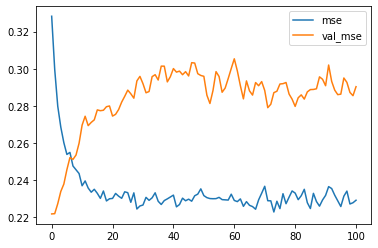

Prediction = 0.0903407633304596
Last corr = -0.510345
pred_col_name lb_peg_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

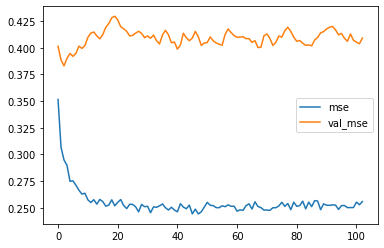

Prediction = 0.06260118633508682
Last corr = -0.942899
pred_col_name lb_mcri_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

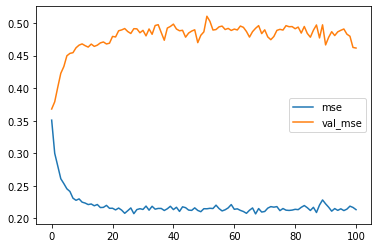

Prediction = 0.009304976090788841
Last corr = -0.680531
pred_col_name lb_bac_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

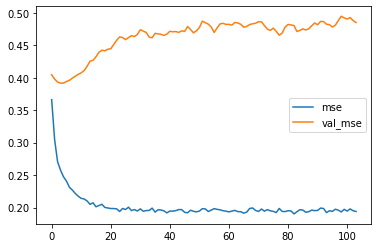

Prediction = 0.2749329209327698
Last corr = -0.853475
pred_col_name lb_seas_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

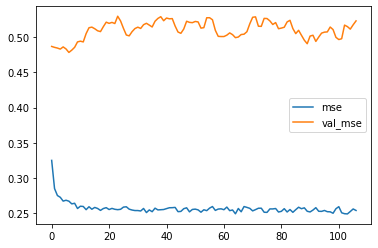

Prediction = 0.06605210155248642
Last corr = -0.781686
pred_col_name lb_ni_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

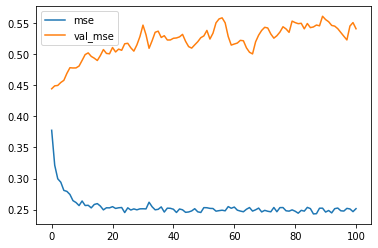

Prediction = 0.1935664713382721
Last corr = -0.954126
pred_col_name lb_chdn_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

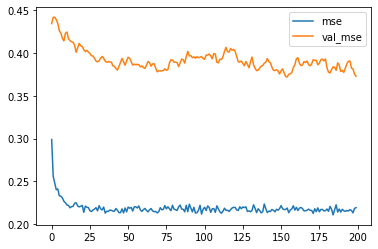

Prediction = 0.23987539112567902
Last corr = -0.807031
pred_col_name lb_six_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

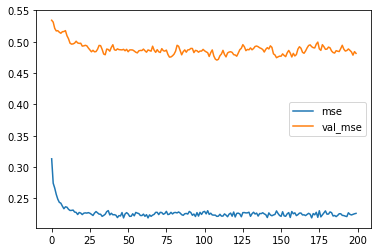

Prediction = 0.0747673362493515
Last corr = -0.905971
pred_col_name lb_pnr_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

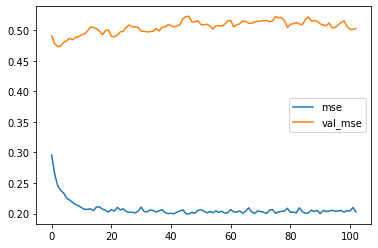

Prediction = 0.22438503801822662
Last corr = -0.83475
pred_col_name lb_ph_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b

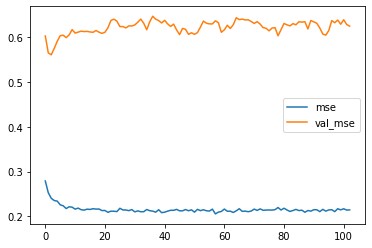

Prediction = 0.21719424426555634
Last corr = -0.926785
pred_col_name lb_ual_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

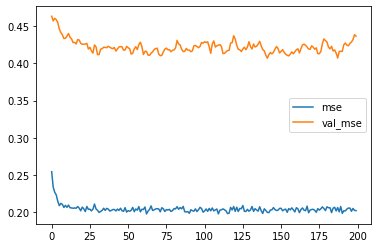

Prediction = 0.2509208917617798
Last corr = -0.848068
pred_col_name lb_vno_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

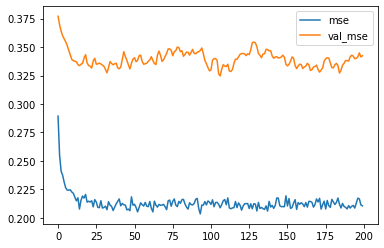

Prediction = 0.3457646071910858
Last corr = -0.641807
pred_col_name lb_penn_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

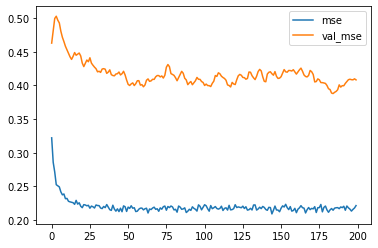

Prediction = 0.26306822896003723
Last corr = -0.631099
pred_col_name lb_so_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

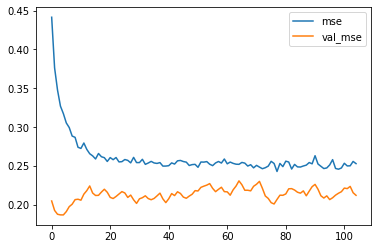

Prediction = 0.08864035457372665
Last corr = -0.339818
pred_col_name lb_znga_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

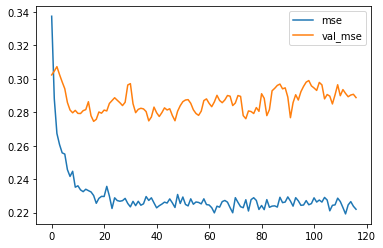

Prediction = 0.013505775481462479
Last corr = -0.331203
pred_col_name lb_rost_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16

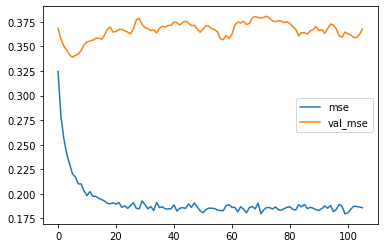

Prediction = 0.07954131066799164
Last corr = -0.67571
pred_col_name lb_ccl_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

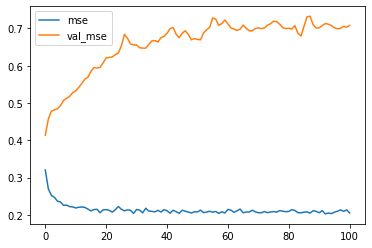

Prediction = 0.1488080769777298
Last corr = -0.890564
pred_col_name lb_eqix_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

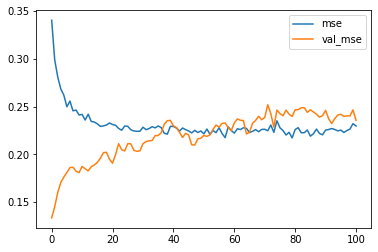

Prediction = 0.10508675873279572
Last corr = 0.211857
pred_col_name lb_nclh_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

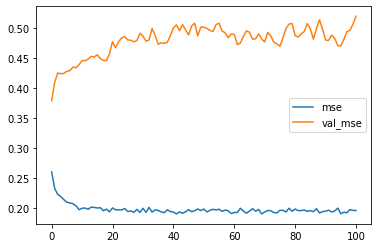

Prediction = 0.2373889982700348
Last corr = -0.734071
pred_col_name lb_mlco_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

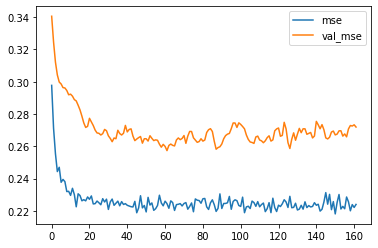

Prediction = 0.034487366676330566
Last corr = -0.327818
pred_col_name lb_ce_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

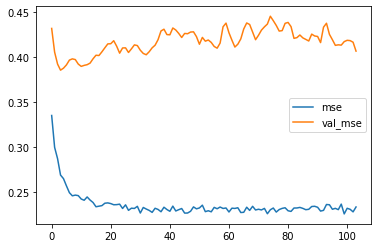

Prediction = 0.0975070595741272
Last corr = -0.809451
pred_col_name lb_cnk_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

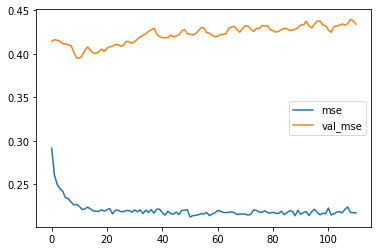

Prediction = 0.21368901431560516
Last corr = -0.773721
pred_col_name lb_atvi_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

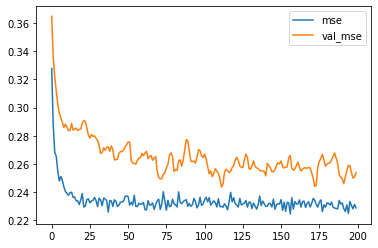

Prediction = 0.1648484468460083
Last corr = 0.238558
pred_col_name lb_emr_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b

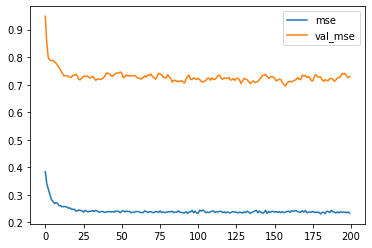

Prediction = 0.28699737787246704
Last corr = -0.954994
pred_col_name lb_czr_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

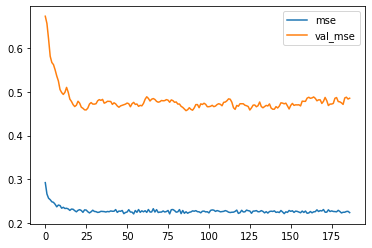

Prediction = 0.15163560211658478
Last corr = -0.732013
pred_col_name lb_rcl_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

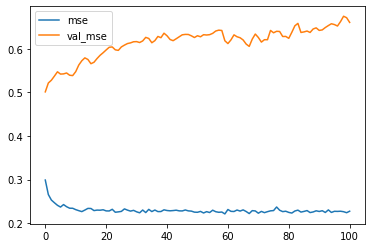

Prediction = 0.05600390210747719
Last corr = -0.846484
pred_col_name lind_pg_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

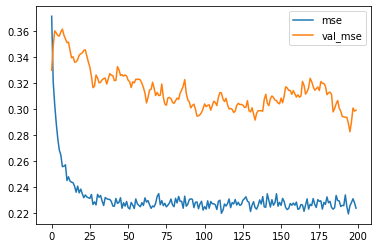

Prediction = 0.2648757994174957
Last corr = 0.949049
pred_col_name lind_mtn_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

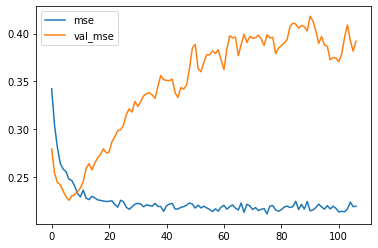

Prediction = 0.2890893518924713
Last corr = 0.953365
pred_col_name lind_are_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

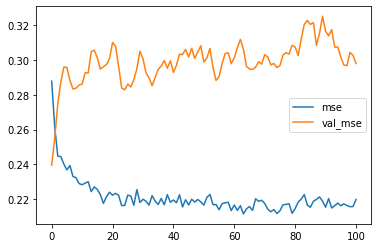

Prediction = 0.24013634026050568
Last corr = 0.944998
pred_col_name lind_gden_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16

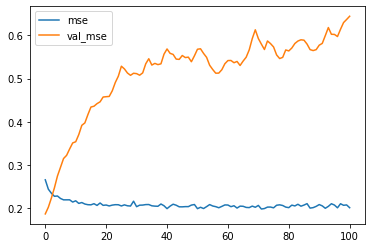

Prediction = 0.24636363983154297
Last corr = 0.824416
pred_col_name lind_lvs_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

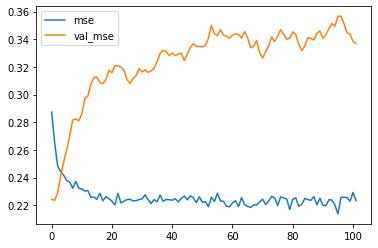

Prediction = 0.3205012083053589
Last corr = 0.796774
pred_col_name lind_fun_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

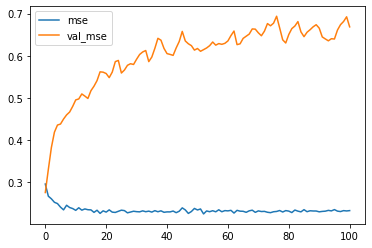

Prediction = 0.28581395745277405
Last corr = 0.909503
pred_col_name lind_rop_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

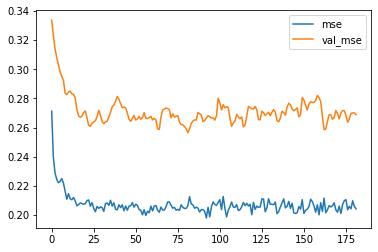

Prediction = 0.34164154529571533
Last corr = 0.805031
pred_col_name lind_peg_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

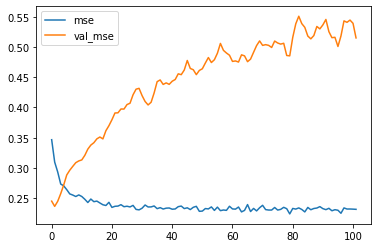

Prediction = 0.37539035081863403
Last corr = 0.877848
pred_col_name lind_mcri_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16

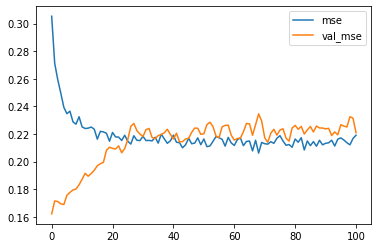

Prediction = 0.28435567021369934
Last corr = 0.847862
pred_col_name lind_bac_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

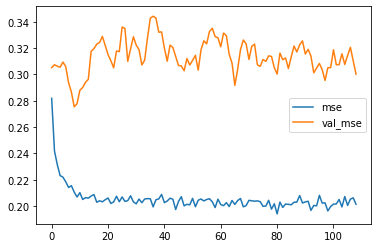

Prediction = 0.46069586277008057
Last corr = 0.965961
pred_col_name lind_seas_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16

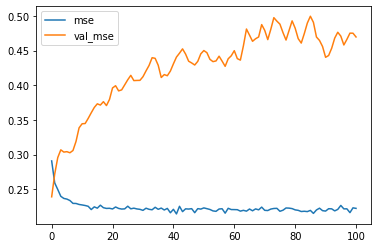

Prediction = 0.30904218554496765
Last corr = 0.915291
pred_col_name lind_ni_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

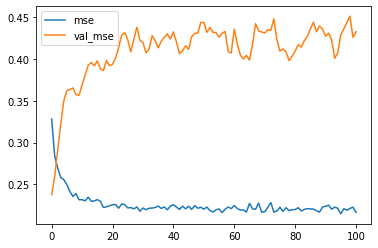

Prediction = 0.38765373826026917
Last corr = 0.942549
pred_col_name lind_chdn_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16

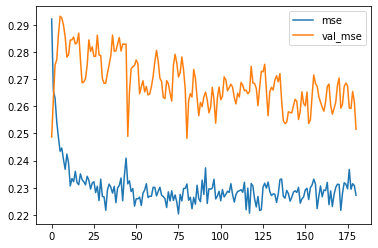

Prediction = 0.2359878420829773
Last corr = 0.904332
pred_col_name lind_six_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

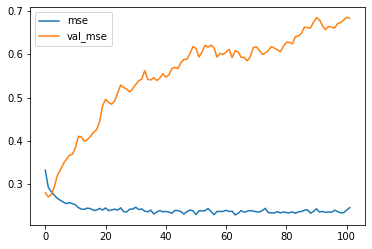

Prediction = 0.24232889711856842
Last corr = 0.953848
pred_col_name lind_pnr_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

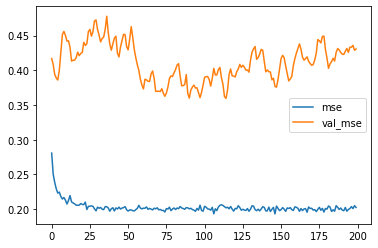

Prediction = 0.14185220003128052
Last corr = 0.963586
pred_col_name lind_ph_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

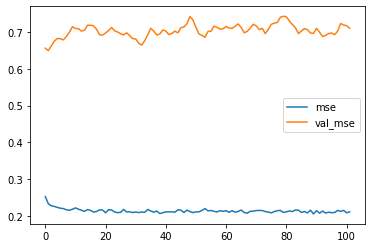

Prediction = 0.1291906237602234
Last corr = 0.96366
pred_col_name lind_ual_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

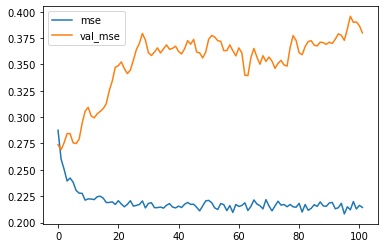

Prediction = 0.3329772353172302
Last corr = 0.947378
pred_col_name lind_vno_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

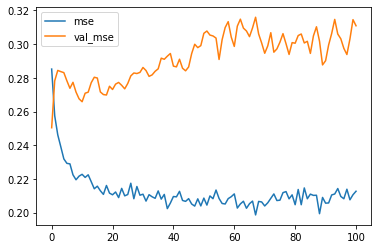

Prediction = 0.25443872809410095
Last corr = 0.341614
pred_col_name lind_penn_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16

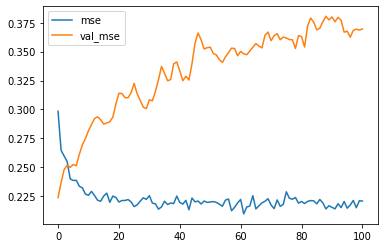

Prediction = 0.25534963607788086
Last corr = 0.808123
pred_col_name lind_so_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

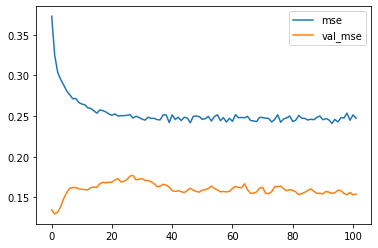

Prediction = 0.2808555066585541
Last corr = 0.404486
pred_col_name lind_znga_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

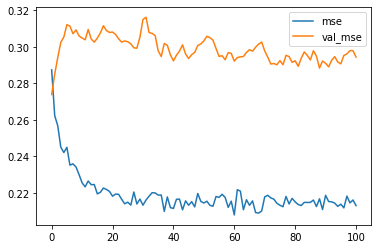

Prediction = 0.15716977417469025
Last corr = 0.560804
pred_col_name lind_rost_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16

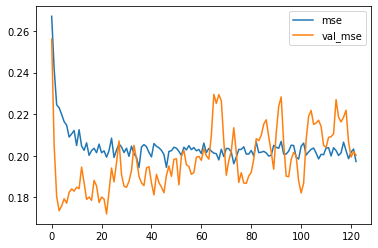

Prediction = 0.4084320366382599
Last corr = 0.854995
pred_col_name lind_ccl_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

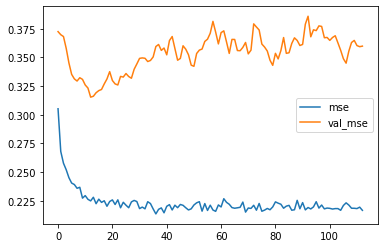

Prediction = 0.2590584456920624
Last corr = 0.971525
pred_col_name lind_eqix_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

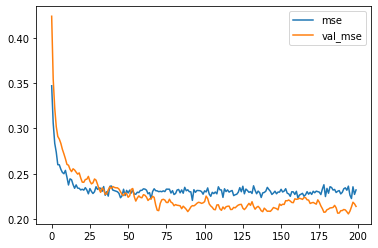

Prediction = -0.09922835975885391
Last corr = 0.008044
pred_col_name lind_nclh_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1

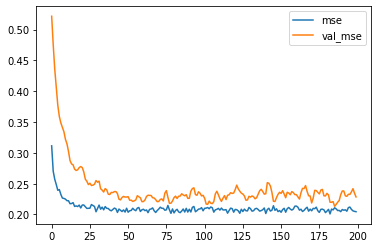

Prediction = 0.1840558499097824
Last corr = 0.916002
pred_col_name lind_mlco_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

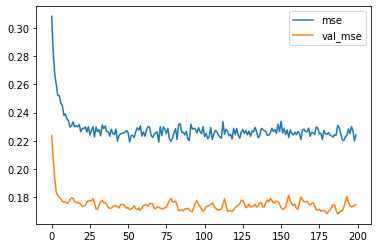

Prediction = -0.07202808558940887
Last corr = 0.029561
pred_col_name lind_ce_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

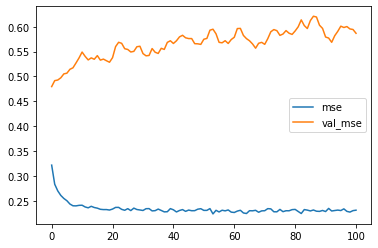

Prediction = -0.11342378705739975
Last corr = 0.862327
pred_col_name lind_cnk_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16

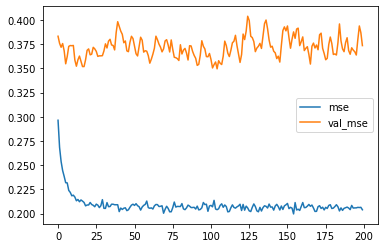

Prediction = 0.28917396068573
Last corr = 0.922227
pred_col_name lind_atvi_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

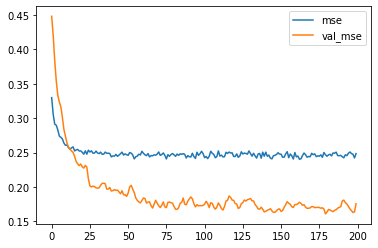

Prediction = -0.1434595286846161
Last corr = -0.320016
pred_col_name lind_emr_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16

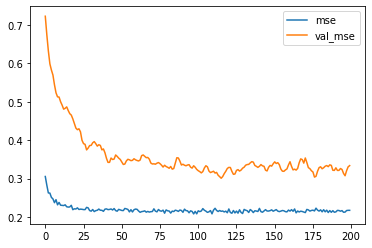

Prediction = 0.48418572545051575
Last corr = 0.956106
pred_col_name lind_czr_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

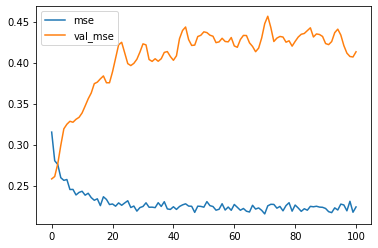

Prediction = 0.09783174097537994
Last corr = 0.882388
pred_col_name lind_rcl_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

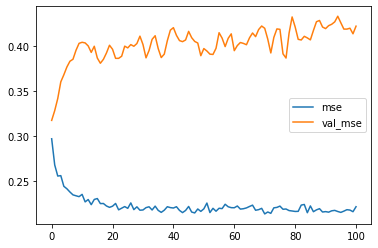

Prediction = 0.31650853157043457
Last corr = 0.927832
pred_col_name pg_mtn_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

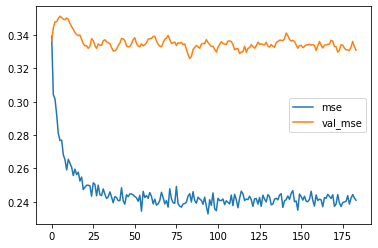

Prediction = 0.2696135640144348
Last corr = 0.974207
pred_col_name pg_are_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b

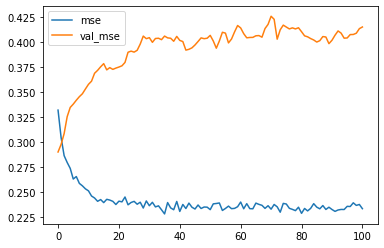

Prediction = 0.2771080434322357
Last corr = 0.962913
pred_col_name pg_gden_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

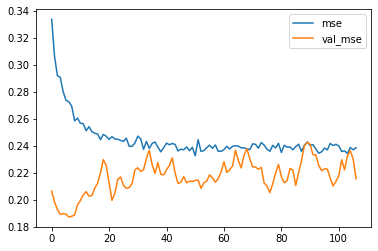

Prediction = 0.3283900320529938
Last corr = 0.770999
pred_col_name pg_lvs_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b

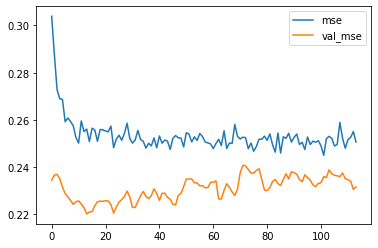

Prediction = 0.18558092415332794
Last corr = 0.849118
pred_col_name pg_fun_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

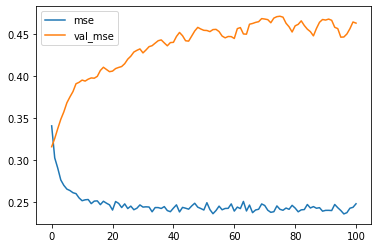

Prediction = 0.10053189843893051
Last corr = 0.885424
pred_col_name pg_rop_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

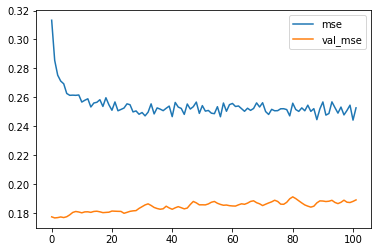

Prediction = 0.3025428056716919
Last corr = 0.598329
pred_col_name pg_peg_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b

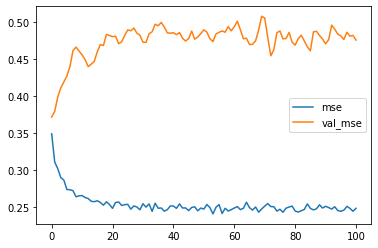

Prediction = 0.004886984825134277
Last corr = 0.925215
pred_col_name pg_mcri_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

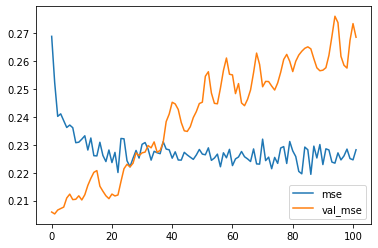

Prediction = 0.2547149360179901
Last corr = 0.815629
pred_col_name pg_bac_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b

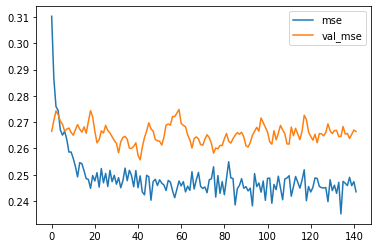

Prediction = 0.14007779955863953
Last corr = 0.90906
pred_col_name pg_seas_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

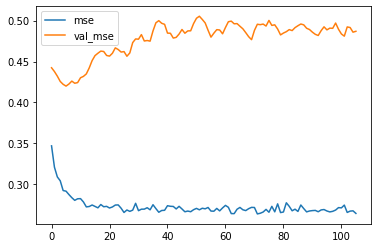

Prediction = 0.03271007537841797
Last corr = 0.894419
pred_col_name pg_ni_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b

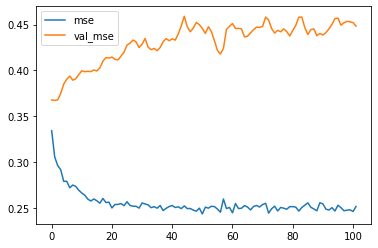

Prediction = 0.11199284344911575
Last corr = 0.98394
pred_col_name pg_chdn_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

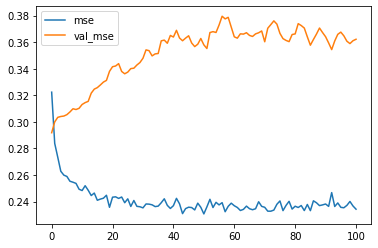

Prediction = 0.4012957811355591
Last corr = 0.902687
pred_col_name pg_six_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b

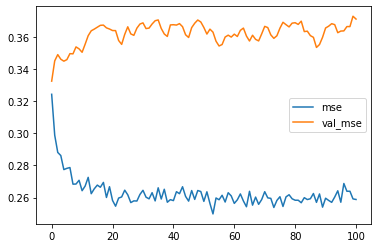

Prediction = 0.3063672184944153
Last corr = 0.984023
pred_col_name pg_pnr_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b

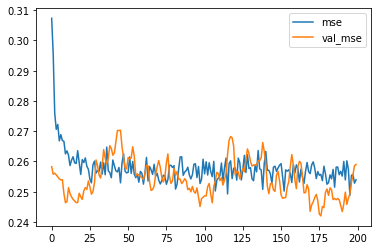

Prediction = 0.19398093223571777
Last corr = 0.945253
pred_col_name pg_ph_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b

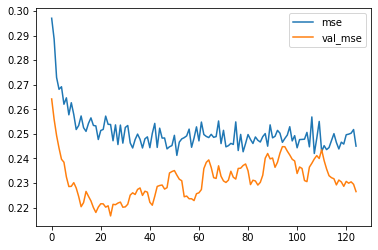

Prediction = 0.376156747341156
Last corr = 0.975821
pred_col_name pg_ual_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b9

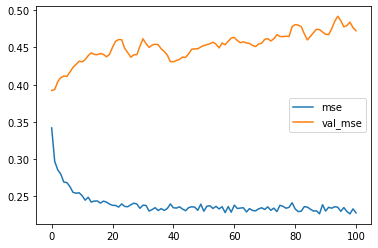

Prediction = 0.3315228521823883
Last corr = 0.947772
pred_col_name pg_vno_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b

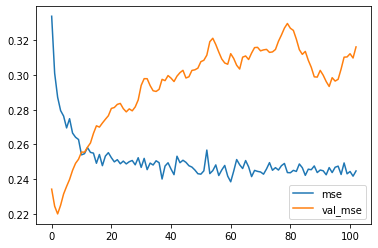

Prediction = 0.03396003693342209
Last corr = 0.449918
pred_col_name pg_penn_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

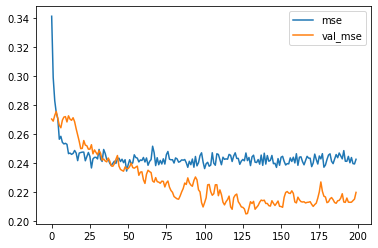

Prediction = 0.6170353889465332
Last corr = 0.787676
pred_col_name pg_so_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b9

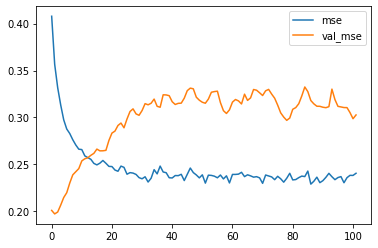

Prediction = 0.25428518652915955
Last corr = 0.36156
pred_col_name pg_znga_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

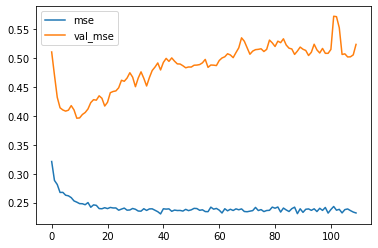

Prediction = 0.2813083231449127
Last corr = 0.510886
pred_col_name pg_rost_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

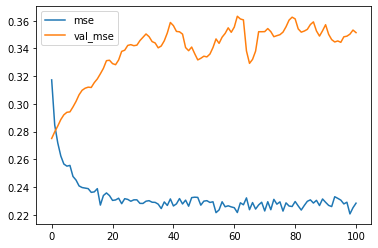

Prediction = 0.20147152245044708
Last corr = 0.829831
pred_col_name pg_ccl_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

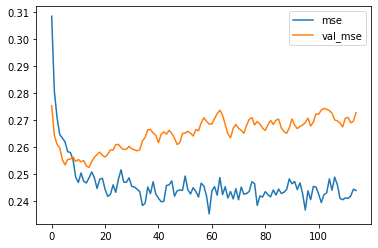

Prediction = 0.12829937040805817
Last corr = 0.963006
pred_col_name pg_eqix_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

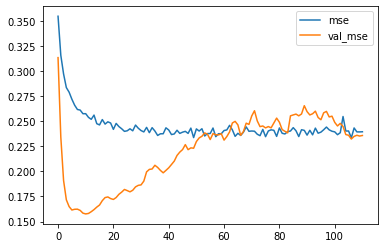

Prediction = 0.07971341907978058
Last corr = -0.133176
pred_col_name pg_nclh_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

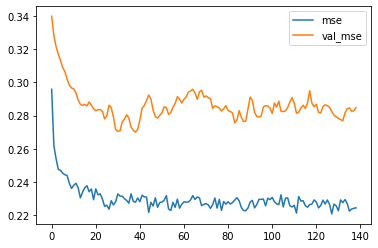

Prediction = 0.12912189960479736
Last corr = 0.886062
pred_col_name pg_mlco_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

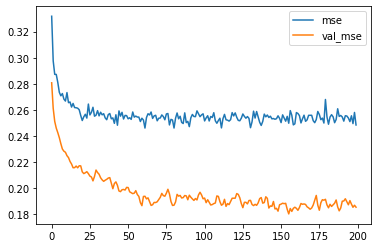

Prediction = 0.2127910703420639
Last corr = 0.081169
pred_col_name pg_ce_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b9

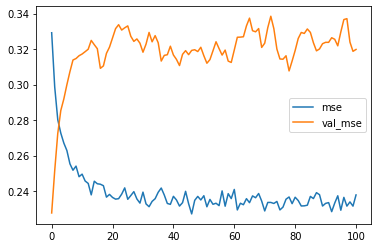

Prediction = 0.1996326446533203
Last corr = 0.870382
pred_col_name pg_cnk_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b

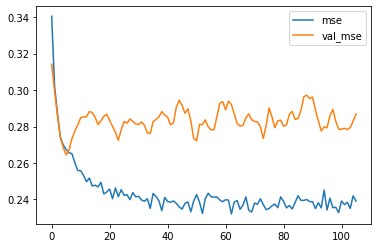

Prediction = 0.26168516278266907
Last corr = 0.885879
pred_col_name pg_atvi_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

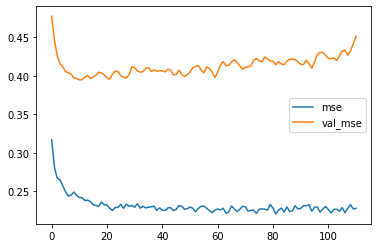

Prediction = 0.0970727726817131
Last corr = -0.369871
pred_col_name pg_emr_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

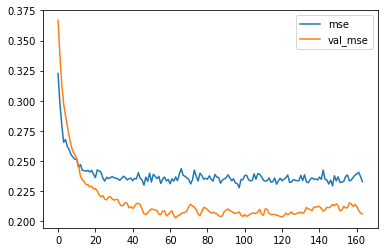

Prediction = 0.4585057199001312
Last corr = 0.970566
pred_col_name pg_czr_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b

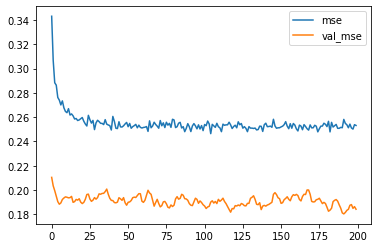

Prediction = 0.2918807566165924
Last corr = 0.856954
pred_col_name pg_rcl_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b

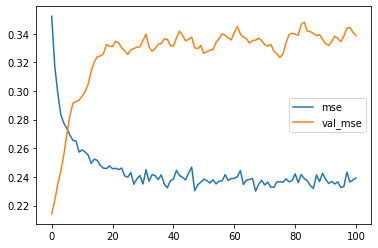

Prediction = 0.09067686647176743
Last corr = 0.934995
pred_col_name mtn_are_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

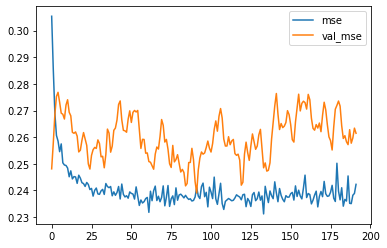

Prediction = 0.20958305895328522
Last corr = 0.983767
pred_col_name mtn_gden_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

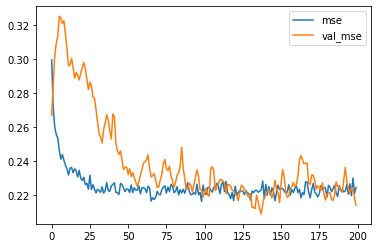

Prediction = 0.16465464234352112
Last corr = 0.870901
pred_col_name mtn_lvs_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

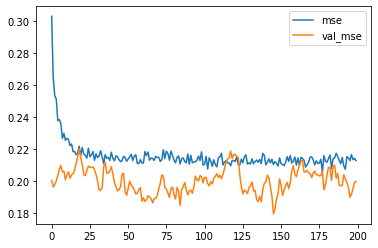

Prediction = 0.2609873116016388
Last corr = 0.757827
pred_col_name mtn_fun_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

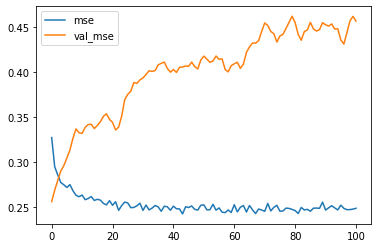

Prediction = 0.3624475300312042
Last corr = 0.959405
pred_col_name mtn_rop_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

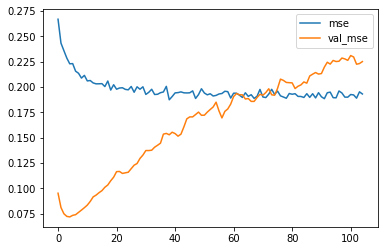

Prediction = 0.44935116171836853
Last corr = 0.667987
pred_col_name mtn_peg_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

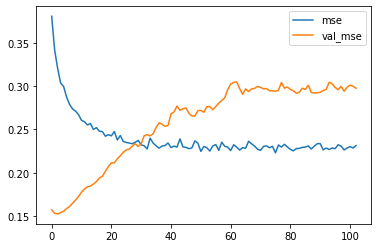

Prediction = 0.4388306438922882
Last corr = 0.827771
pred_col_name mtn_mcri_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

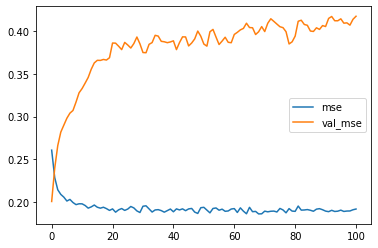

Prediction = 0.4431031346321106
Last corr = 0.900679
pred_col_name mtn_bac_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

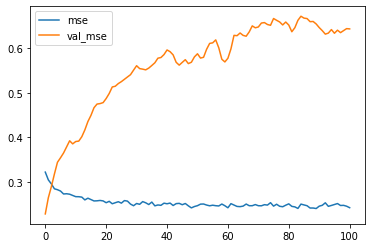

Prediction = 0.3489518165588379
Last corr = 0.886996
pred_col_name mtn_seas_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

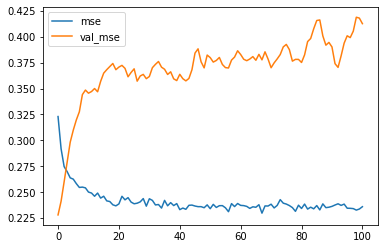

Prediction = 0.3514154255390167
Last corr = 0.962132
pred_col_name mtn_ni_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b

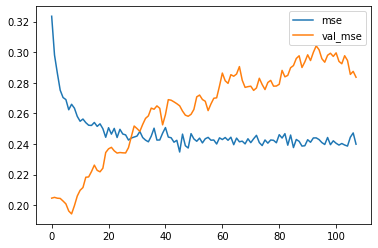

Prediction = 0.25575771927833557
Last corr = 0.936477
pred_col_name mtn_chdn_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

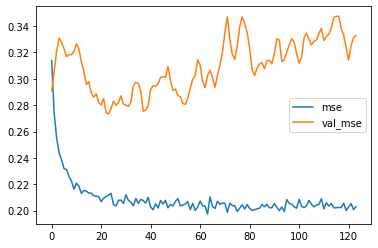

Prediction = 0.40545162558555603
Last corr = 0.952667
pred_col_name mtn_six_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

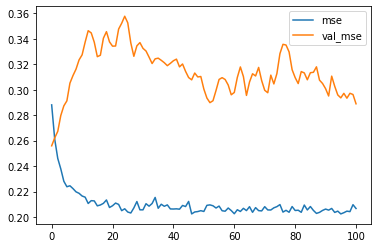

Prediction = 0.5294668078422546
Last corr = 0.998317
pred_col_name mtn_pnr_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

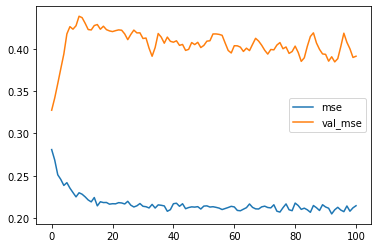

Prediction = 0.3061363101005554
Last corr = 0.982926
pred_col_name mtn_ph_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b

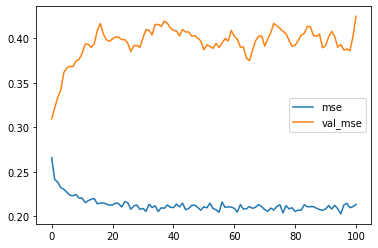

Prediction = 0.3889623284339905
Last corr = 0.979834
pred_col_name mtn_ual_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

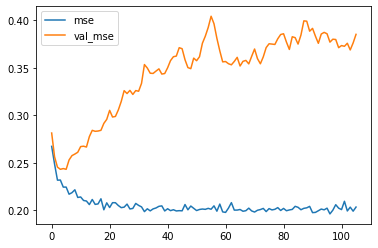

Prediction = 0.34743642807006836
Last corr = 0.972649
pred_col_name mtn_vno_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

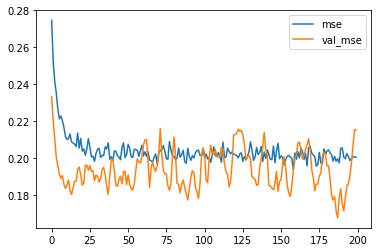

Prediction = -0.010177075862884521
Last corr = 0.27169
pred_col_name mtn_penn_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16

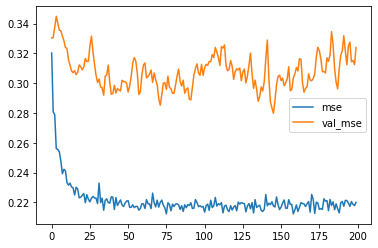

Prediction = 0.1231144443154335
Last corr = 0.891406
pred_col_name mtn_so_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b

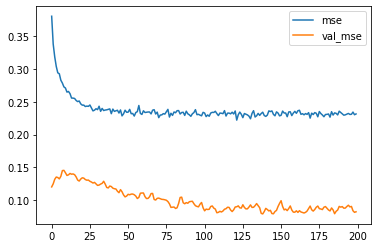

Prediction = 0.2904552221298218
Last corr = 0.285355
pred_col_name mtn_znga_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

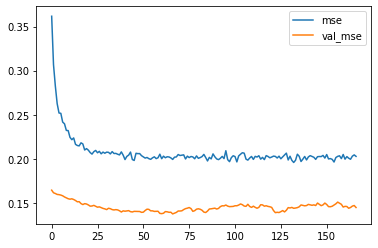

Prediction = 0.21970458328723907
Last corr = 0.672545
pred_col_name mtn_rost_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

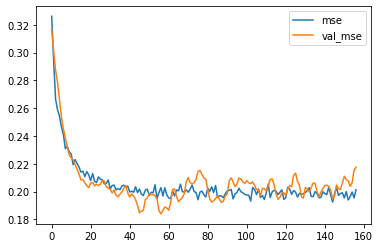

Prediction = 0.36069807410240173
Last corr = 0.905605
pred_col_name mtn_ccl_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

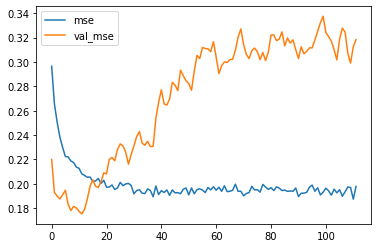

Prediction = 0.3742483854293823
Last corr = 0.96945
pred_col_name mtn_eqix_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

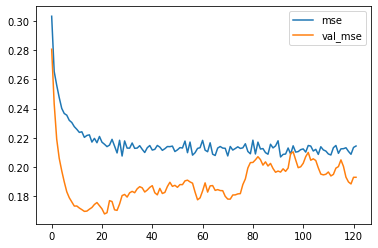

Prediction = -0.004644846543669701
Last corr = -0.084806
pred_col_name mtn_nclh_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x

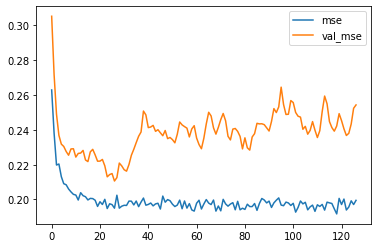

Prediction = 0.2936873435974121
Last corr = 0.953217
pred_col_name mtn_mlco_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

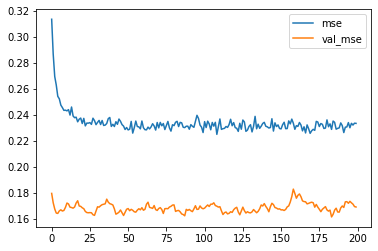

Prediction = 0.1232915073633194
Last corr = -0.090683
pred_col_name mtn_ce_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

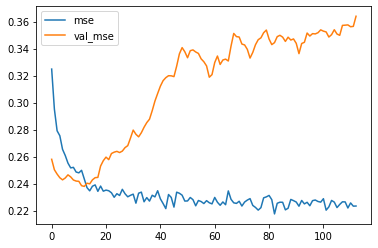

Prediction = 0.0403045192360878
Last corr = 0.928585
pred_col_name mtn_cnk_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

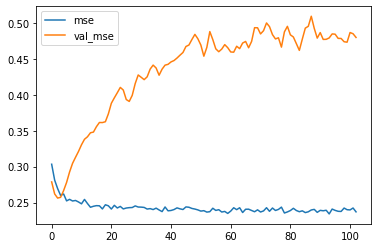

Prediction = 0.2086023986339569
Last corr = 0.932343
pred_col_name mtn_atvi_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

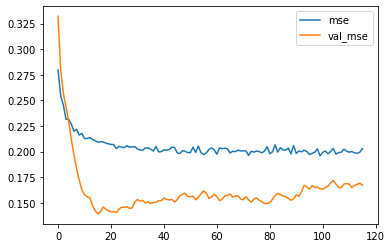

Prediction = 0.12739907205104828
Last corr = -0.3501
pred_col_name mtn_emr_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

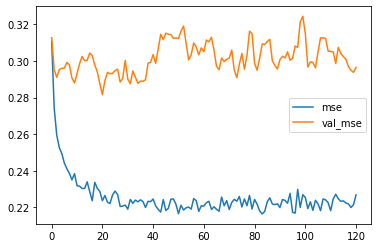

Prediction = 0.2770675718784332
Last corr = 0.926686
pred_col_name mtn_czr_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

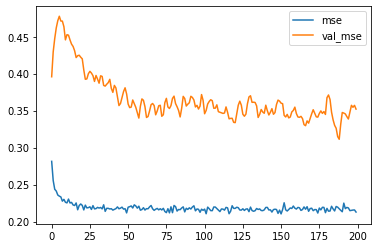

Prediction = 0.07997039705514908
Last corr = 0.934176
pred_col_name mtn_rcl_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

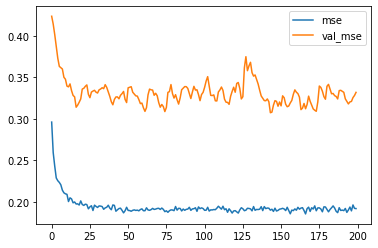

Prediction = 0.36359456181526184
Last corr = 0.953615
pred_col_name are_gden_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

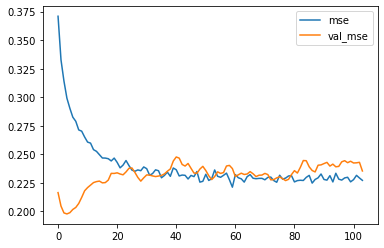

Prediction = 0.4026668071746826
Last corr = 0.881153
pred_col_name are_lvs_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

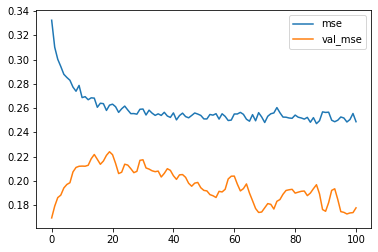

Prediction = 0.4125422537326813
Last corr = 0.765127
pred_col_name are_fun_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

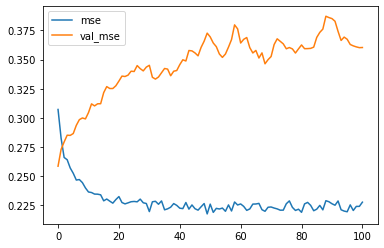

Prediction = 0.348011314868927
Last corr = 0.950643
pred_col_name are_rop_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b

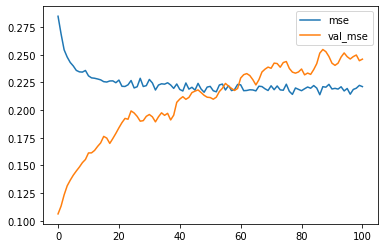

Prediction = 0.34614866971969604
Last corr = 0.701924
pred_col_name are_peg_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

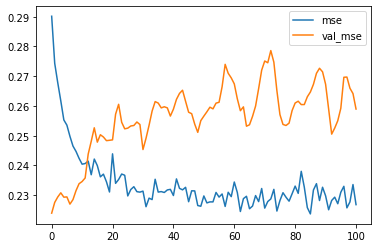

Prediction = 0.24011744558811188
Last corr = 0.830947
pred_col_name are_mcri_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

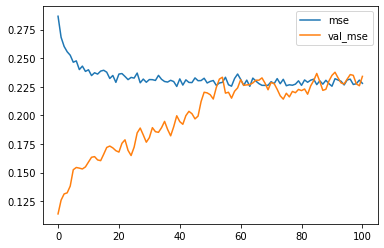

Prediction = 0.44803115725517273
Last corr = 0.896244
pred_col_name are_bac_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

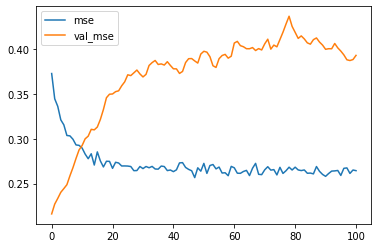

Prediction = 0.36624184250831604
Last corr = 0.870912
pred_col_name are_seas_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

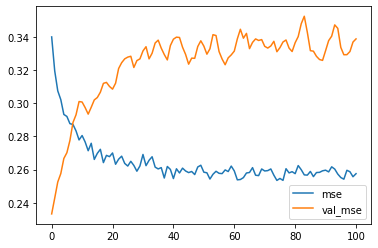

Prediction = 0.3081514835357666
Last corr = 0.956123
pred_col_name are_ni_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b

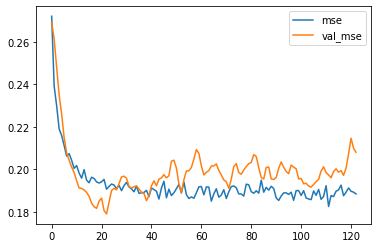

Prediction = 0.510425329208374
Last corr = 0.938645
pred_col_name are_chdn_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

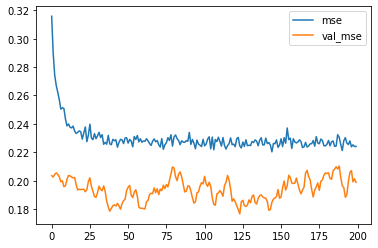

Prediction = 0.41587844491004944
Last corr = 0.968341
pred_col_name are_six_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

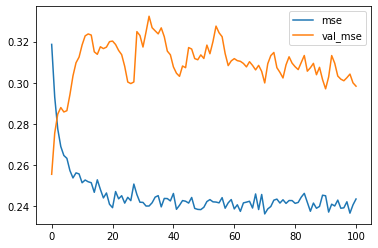

Prediction = 0.22853639721870422
Last corr = 0.986648
pred_col_name are_pnr_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

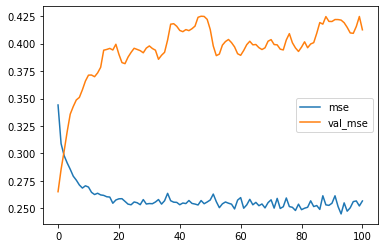

Prediction = 0.31725165247917175
Last corr = 0.970849
pred_col_name are_ph_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

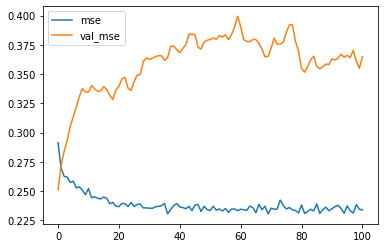

Prediction = 0.311428427696228
Last corr = 0.980968
pred_col_name are_ual_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b

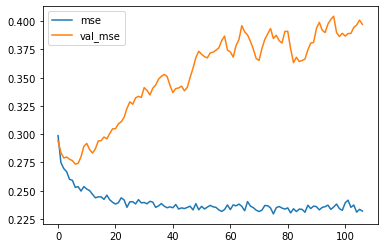

Prediction = 0.27142244577407837
Last corr = 0.947909
pred_col_name are_vno_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

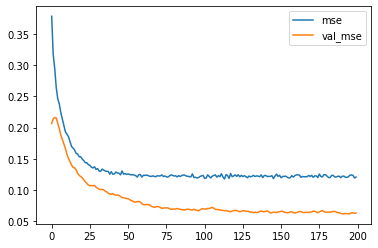

Prediction = 0.5477319359779358
Last corr = 0.253504
pred_col_name are_penn_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

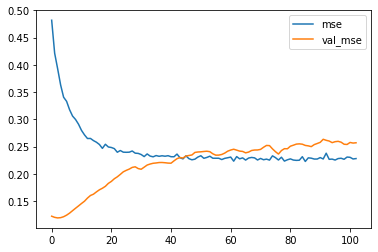

Prediction = 0.5377619862556458
Last corr = 0.87435
pred_col_name are_so_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b9

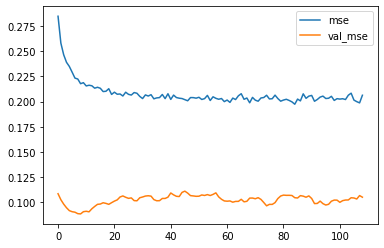

Prediction = 0.41270554065704346
Last corr = 0.348057
pred_col_name are_znga_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

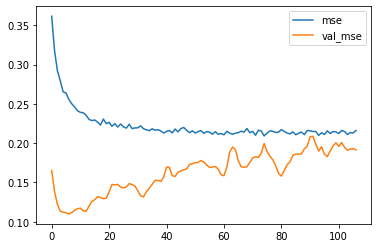

Prediction = 0.4099676311016083
Last corr = 0.70926
pred_col_name are_rost_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

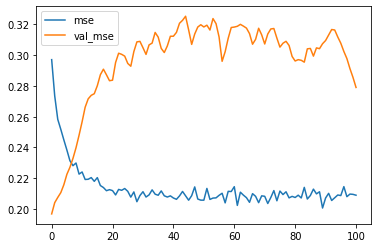

Prediction = 0.3188522458076477
Last corr = 0.836594
pred_col_name are_ccl_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

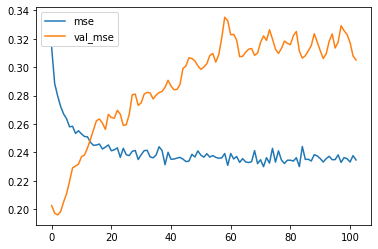

Prediction = 0.4470405578613281
Last corr = 0.935208
pred_col_name are_eqix_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

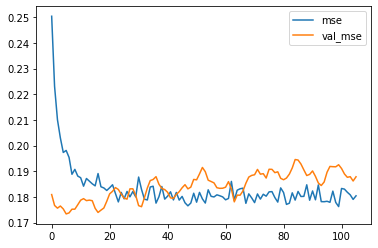

Prediction = 0.44415363669395447
Last corr = 0.025376
pred_col_name are_nclh_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

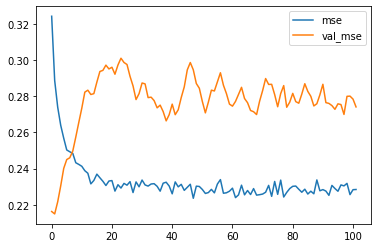

Prediction = 0.40754565596580505
Last corr = 0.908754
pred_col_name are_mlco_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

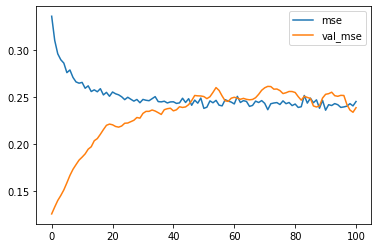

Prediction = 0.367626816034317
Last corr = -0.038397
pred_col_name are_ce_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b

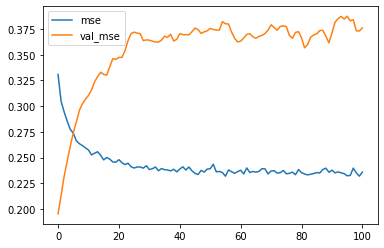

Prediction = 0.2783695459365845
Last corr = 0.925464
pred_col_name are_cnk_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

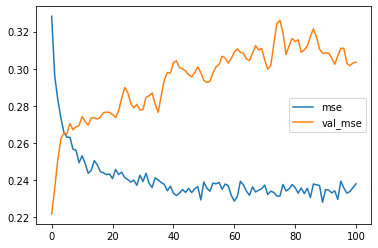

Prediction = 0.37572312355041504
Last corr = 0.916279
pred_col_name are_atvi_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

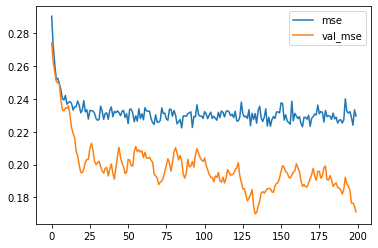

Prediction = 0.19389396905899048
Last corr = -0.218288
pred_col_name are_emr_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

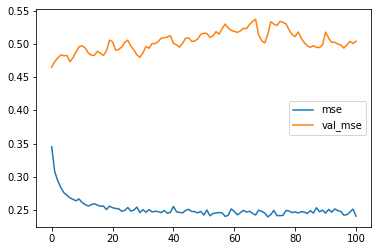

Prediction = 0.3607707619667053
Last corr = 0.925045
pred_col_name are_czr_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

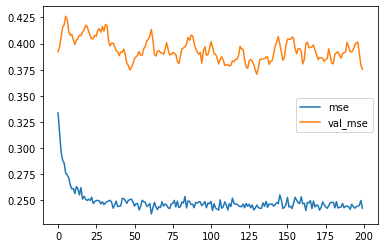

Prediction = 0.0265052393078804
Last corr = 0.93184
pred_col_name are_rcl_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b

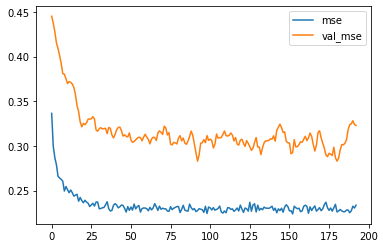

Prediction = 0.14544709026813507
Last corr = 0.907469
pred_col_name gden_lvs_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

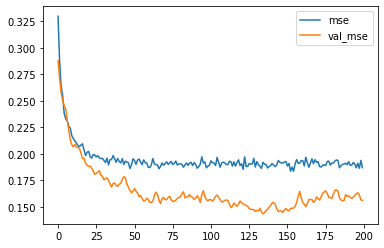

Prediction = 0.4454551935195923
Last corr = 0.614546
pred_col_name gden_fun_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

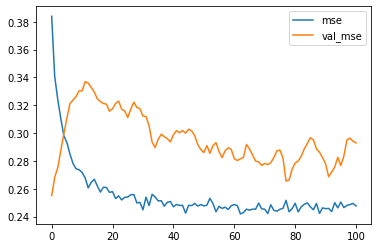

Prediction = 0.23973584175109863
Last corr = 0.947526
pred_col_name gden_rop_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

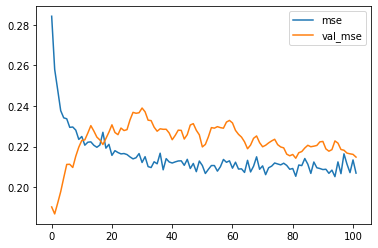

Prediction = 0.44316166639328003
Last corr = 0.780162
pred_col_name gden_peg_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

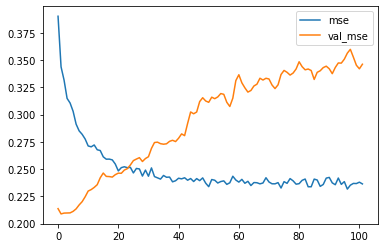

Prediction = 0.40767717361450195
Last corr = 0.554214
pred_col_name gden_mcri_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16

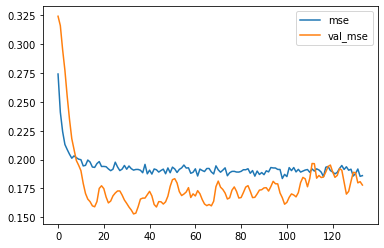

Prediction = 0.4845985770225525
Last corr = 0.992224
pred_col_name gden_bac_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

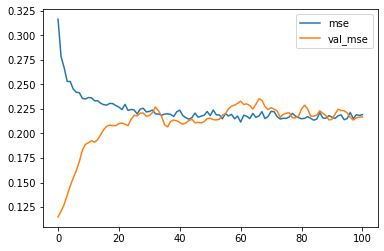

Prediction = 0.43338459730148315
Last corr = 0.782025
pred_col_name gden_seas_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16

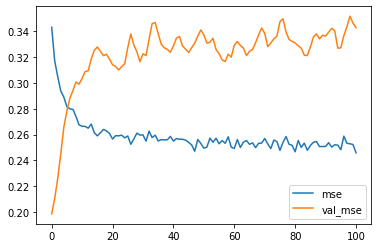

Prediction = 0.37630677223205566
Last corr = 0.968702
pred_col_name gden_ni_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

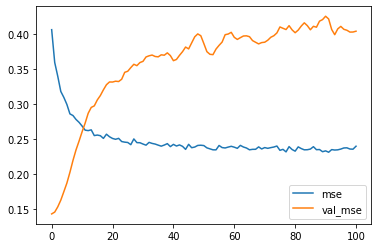

Prediction = 0.3638240694999695
Last corr = 0.711364
pred_col_name gden_chdn_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

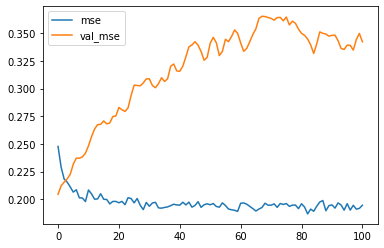

Prediction = 0.3878038227558136
Last corr = 0.964094
pred_col_name gden_six_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

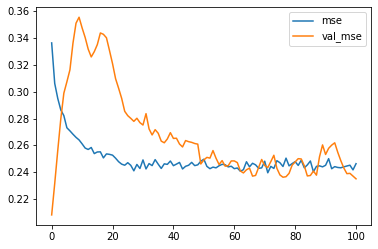

Prediction = 0.2930787205696106
Last corr = 0.853617
pred_col_name gden_pnr_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

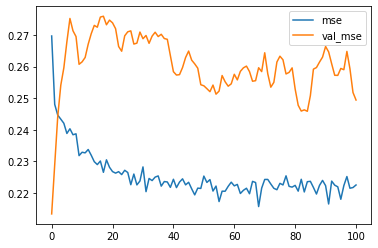

Prediction = 0.2767740488052368
Last corr = 0.919367
pred_col_name gden_ph_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

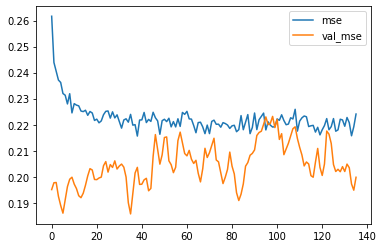

Prediction = 0.21909037232398987
Last corr = 0.871094
pred_col_name gden_ual_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

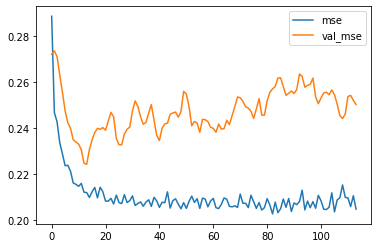

Prediction = 0.4929996430873871
Last corr = 0.90333
pred_col_name gden_vno_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

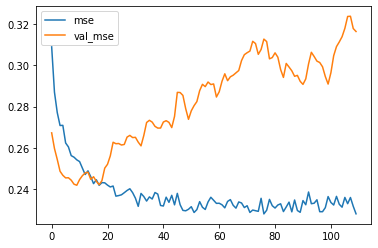

Prediction = 0.1936752051115036
Last corr = -0.147665
pred_col_name gden_penn_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16

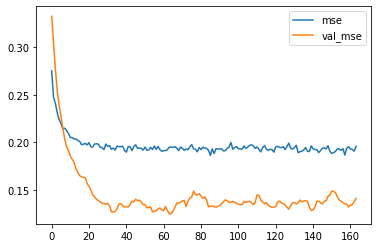

Prediction = 0.3155030310153961
Last corr = 0.981628
pred_col_name gden_so_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

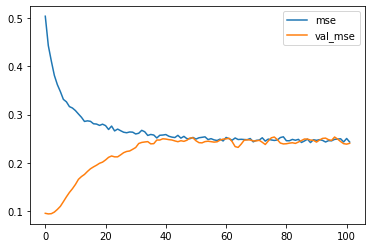

Prediction = 0.30239689350128174
Last corr = 0.329564
pred_col_name gden_znga_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16

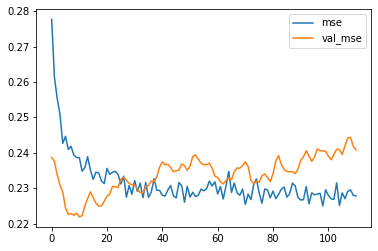

Prediction = 0.26202887296676636
Last corr = 0.877404
pred_col_name gden_rost_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16

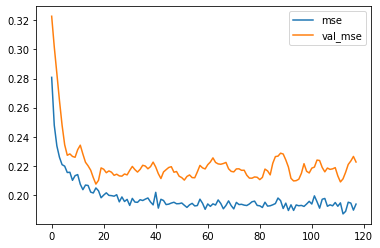

Prediction = 0.2029018998146057
Last corr = 0.884589
pred_col_name gden_ccl_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

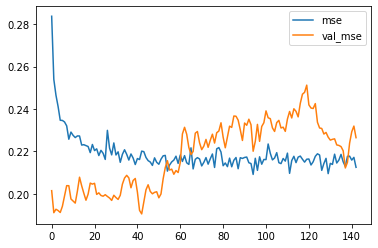

Prediction = 0.297650545835495
Last corr = 0.769818
pred_col_name gden_eqix_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

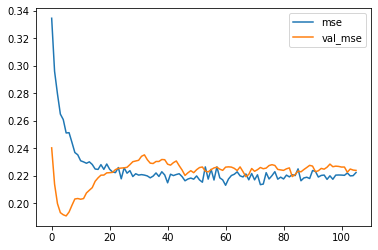

Prediction = 0.09690292179584503
Last corr = 0.00188
pred_col_name gden_nclh_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

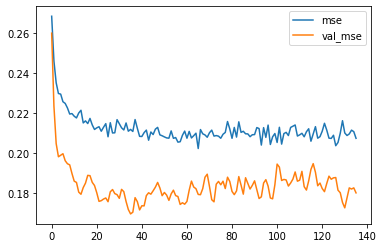

Prediction = 0.5212382078170776
Last corr = 0.908379
pred_col_name gden_mlco_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

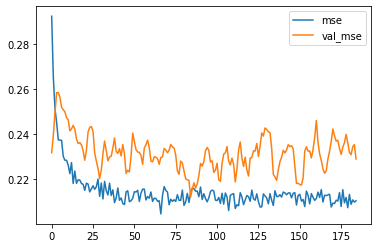

Prediction = 0.33150914311408997
Last corr = -0.190344
pred_col_name gden_ce_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

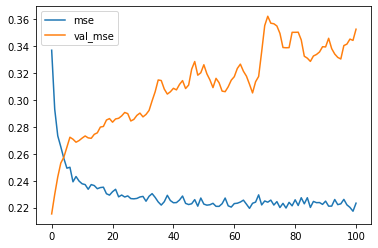

Prediction = 0.2617664039134979
Last corr = 0.869435
pred_col_name gden_cnk_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

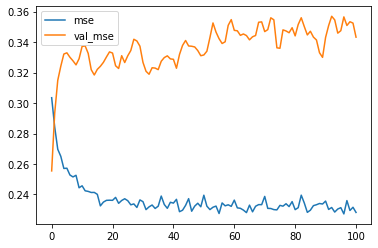

Prediction = 0.28502362966537476
Last corr = 0.94978
pred_col_name gden_atvi_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

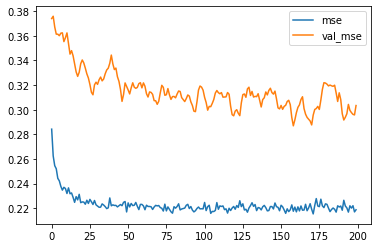

Prediction = 0.2596015930175781
Last corr = -0.153864
pred_col_name gden_emr_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

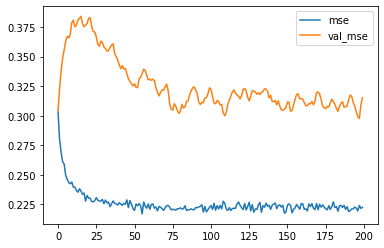

Prediction = 0.09102626889944077
Last corr = 0.768448
pred_col_name gden_czr_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

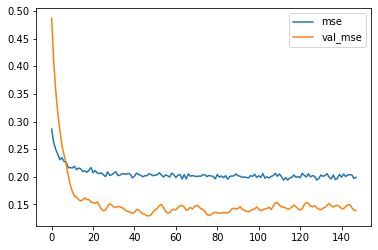

Prediction = 0.45733416080474854
Last corr = 0.987386
pred_col_name gden_rcl_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

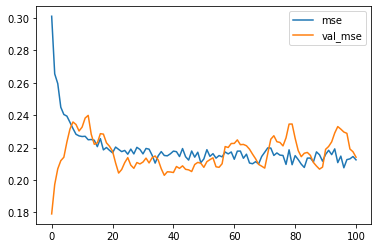

Prediction = 0.2513655722141266
Last corr = 0.727481
pred_col_name lvs_fun_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

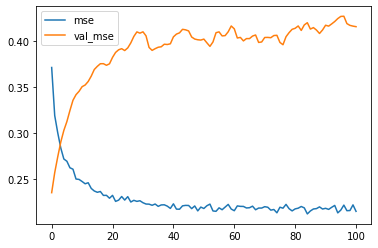

Prediction = 0.3125925064086914
Last corr = 0.626344
pred_col_name lvs_rop_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

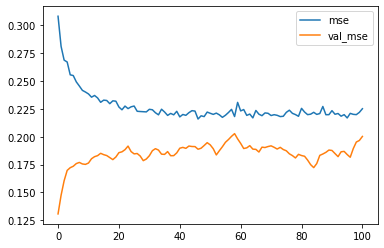

Prediction = 0.2565903961658478
Last corr = 0.529084
pred_col_name lvs_peg_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

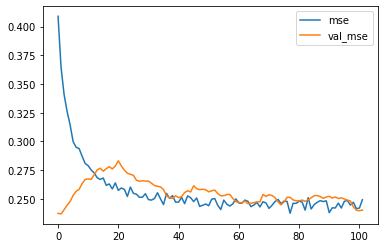

Prediction = 0.2385825216770172
Last corr = 0.873075
pred_col_name lvs_mcri_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

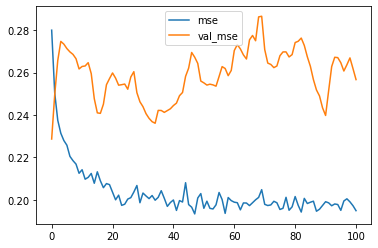

Prediction = 0.31030040979385376
Last corr = 0.666804
pred_col_name lvs_bac_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

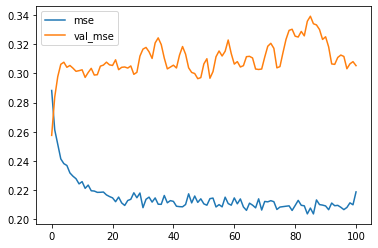

Prediction = 0.3135659694671631
Last corr = 0.862746
pred_col_name lvs_seas_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

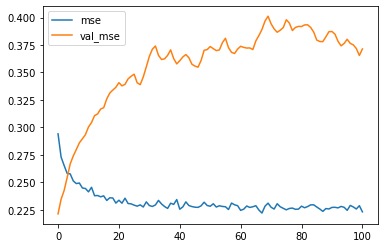

Prediction = 0.2858273684978485
Last corr = 0.715176
pred_col_name lvs_ni_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b

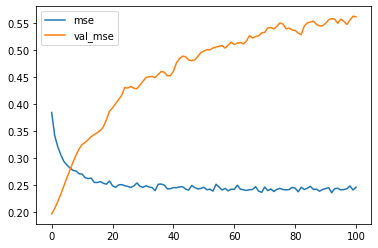

Prediction = 0.3486509919166565
Last corr = 0.839491
pred_col_name lvs_chdn_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

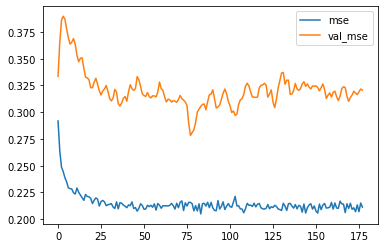

Prediction = 0.37484192848205566
Last corr = 0.752236
pred_col_name lvs_six_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

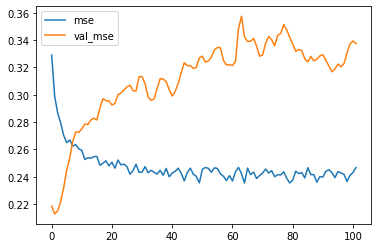

Prediction = 0.32357263565063477
Last corr = 0.776768
pred_col_name lvs_pnr_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

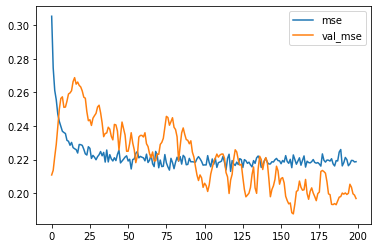

Prediction = 0.34254351258277893
Last corr = 0.752207
pred_col_name lvs_ph_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

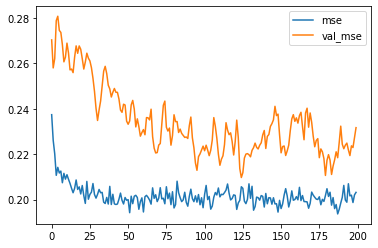

Prediction = 0.20405396819114685
Last corr = 0.856584
pred_col_name lvs_ual_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

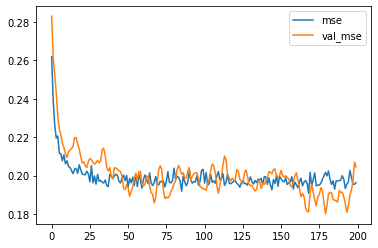

Prediction = 0.3015744090080261
Last corr = 0.800834
pred_col_name lvs_vno_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

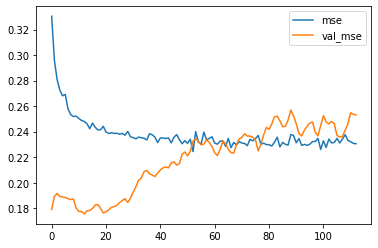

Prediction = 0.18947142362594604
Last corr = 0.594031
pred_col_name lvs_penn_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

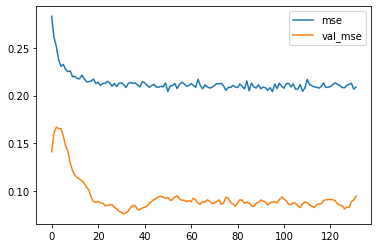

Prediction = 0.453670859336853
Last corr = 0.585564
pred_col_name lvs_so_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b9

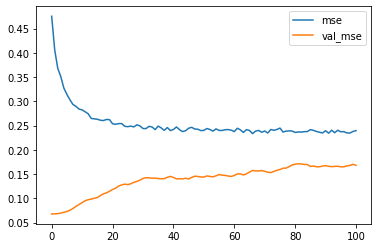

Prediction = 0.29660797119140625
Last corr = 0.473421
pred_col_name lvs_znga_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

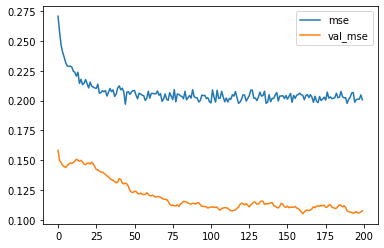

Prediction = 0.16446754336357117
Last corr = 0.212121
pred_col_name lvs_rost_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

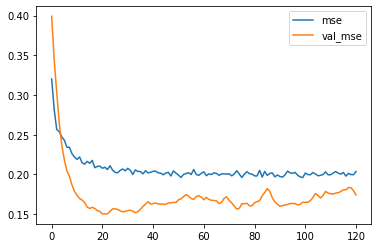

Prediction = 0.27457788586616516
Last corr = 0.626676
pred_col_name lvs_ccl_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

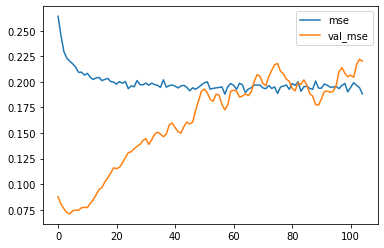

Prediction = 0.41830378770828247
Last corr = 0.749693
pred_col_name lvs_eqix_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

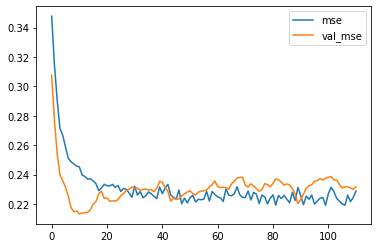

Prediction = 0.21162743866443634
Last corr = -0.370753
pred_col_name lvs_nclh_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16

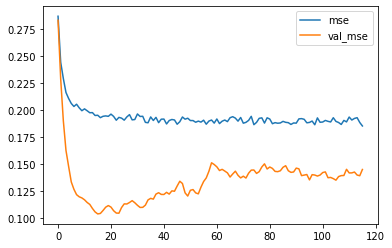

Prediction = 0.5030134916305542
Last corr = 0.644701
pred_col_name lvs_mlco_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

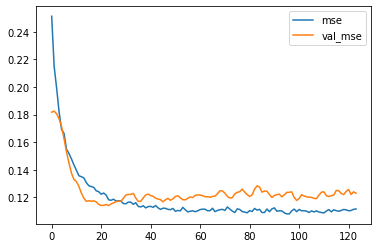

Prediction = 0.5495532751083374
Last corr = 0.551279
pred_col_name lvs_ce_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b

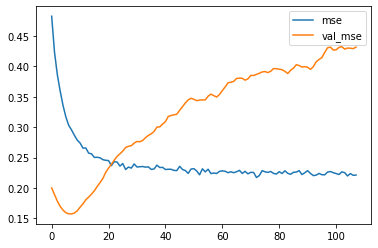

Prediction = 0.47459712624549866
Last corr = 0.692907
pred_col_name lvs_cnk_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

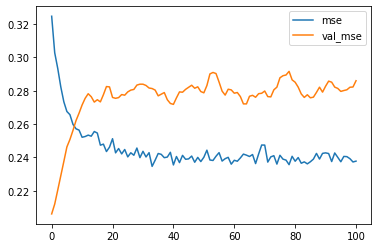

Prediction = 0.4028328061103821
Last corr = 0.774776
pred_col_name lvs_atvi_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

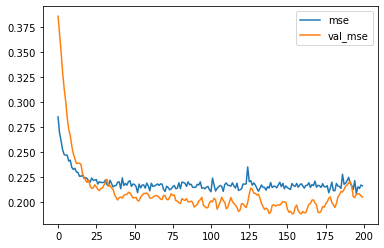

Prediction = 0.3088323473930359
Last corr = -0.191887
pred_col_name lvs_emr_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

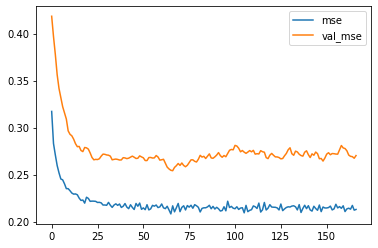

Prediction = 0.37044113874435425
Last corr = 0.92942
pred_col_name lvs_czr_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

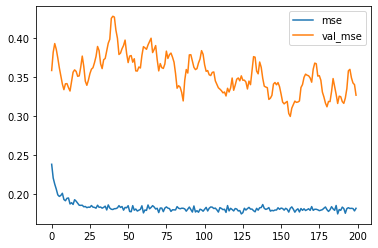

Prediction = 0.377779483795166
Last corr = 0.690787
pred_col_name lvs_rcl_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b

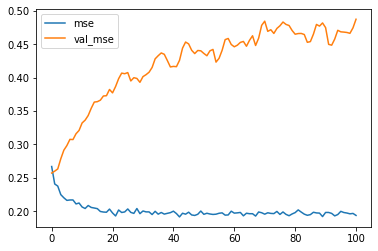

Prediction = 0.2665998041629791
Last corr = 0.656069
pred_col_name fun_rop_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

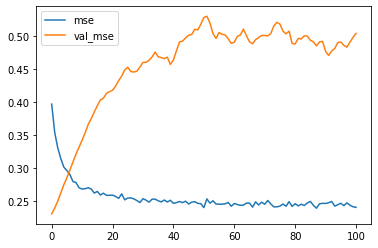

Prediction = 0.3978336751461029
Last corr = 0.725194
pred_col_name fun_peg_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

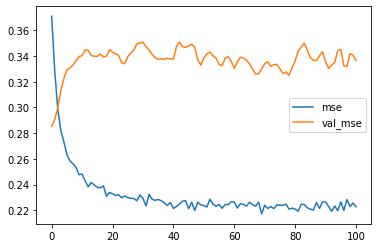

Prediction = 0.3883448839187622
Last corr = 0.705431
pred_col_name fun_mcri_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

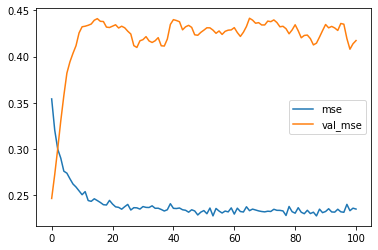

Prediction = 0.36217203736305237
Last corr = 0.959928
pred_col_name fun_bac_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

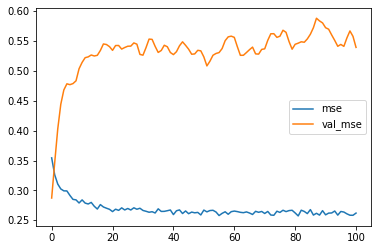

Prediction = 0.2735927999019623
Last corr = 0.845092
pred_col_name fun_seas_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

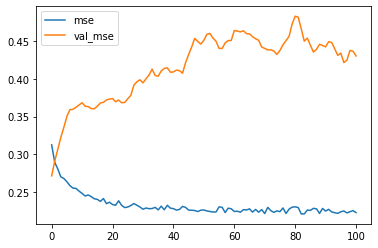

Prediction = 0.2523374557495117
Last corr = 0.976365
pred_col_name fun_ni_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b

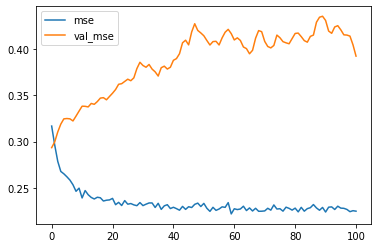

Prediction = 0.19311991333961487
Last corr = 0.849111
pred_col_name fun_chdn_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

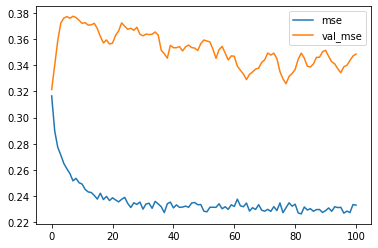

Prediction = 0.16685152053833008
Last corr = 0.967336
pred_col_name fun_six_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

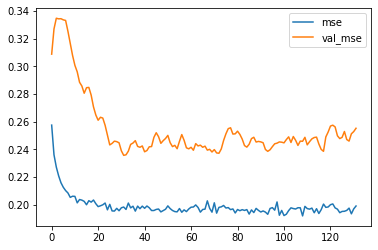

Prediction = 0.45080310106277466
Last corr = 0.949507
pred_col_name fun_pnr_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

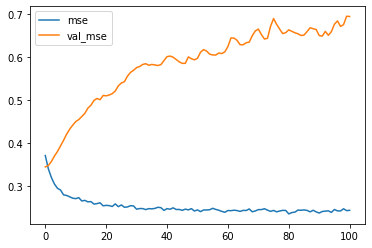

Prediction = 0.373820960521698
Last corr = 0.981551
pred_col_name fun_ph_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b9

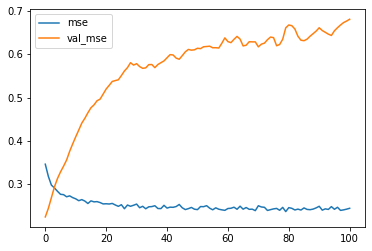

Prediction = 0.31595978140830994
Last corr = 0.922312
pred_col_name fun_ual_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

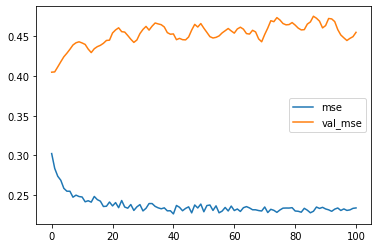

Prediction = 0.4897363781929016
Last corr = 0.958572
pred_col_name fun_vno_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

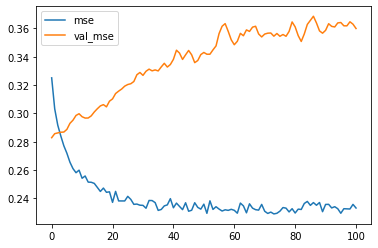

Prediction = 0.30358806252479553
Last corr = -0.002697
pred_col_name fun_penn_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16

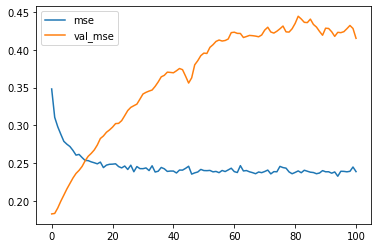

Prediction = 0.34734082221984863
Last corr = 0.960736
pred_col_name fun_so_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

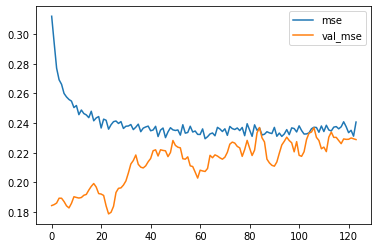

Prediction = 0.3257961869239807
Last corr = 0.349162
pred_col_name fun_znga_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

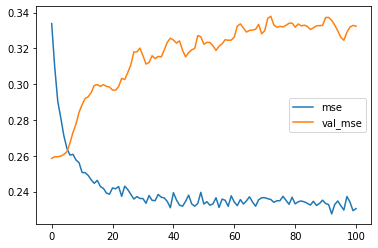

Prediction = 0.21108874678611755
Last corr = 0.817067
pred_col_name fun_rost_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

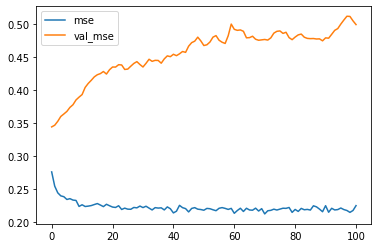

Prediction = 0.2809789180755615
Last corr = 0.927783
pred_col_name fun_ccl_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

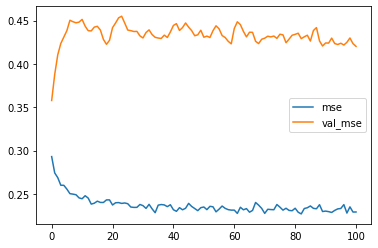

Prediction = 0.27058833837509155
Last corr = 0.895007
pred_col_name fun_eqix_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

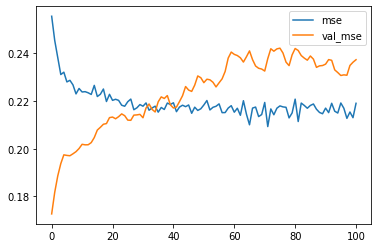

Prediction = 0.21741344034671783
Last corr = 0.054868
pred_col_name fun_nclh_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

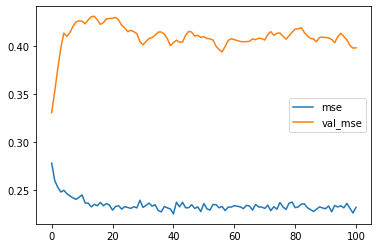

Prediction = 0.3462771475315094
Last corr = 0.976603
pred_col_name fun_mlco_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

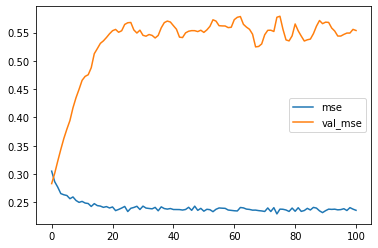

Prediction = 0.24182084202766418
Last corr = -0.276113
pred_col_name fun_ce_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

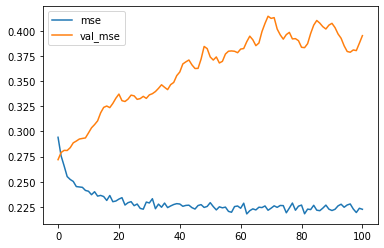

Prediction = 0.2086632251739502
Last corr = 0.880568
pred_col_name fun_cnk_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

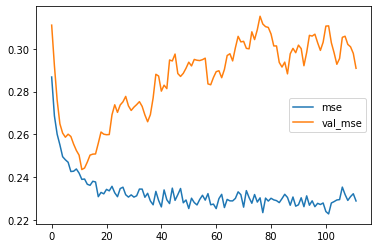

Prediction = 0.18400141596794128
Last corr = 0.953872
pred_col_name fun_atvi_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

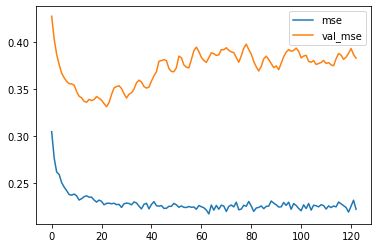

Prediction = 0.23108716309070587
Last corr = -0.349508
pred_col_name fun_emr_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

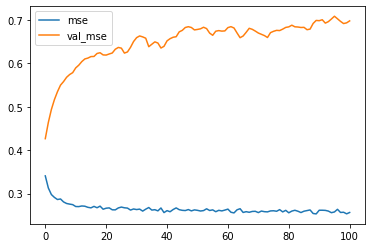

Prediction = 0.2141149491071701
Last corr = 0.841199
pred_col_name fun_czr_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

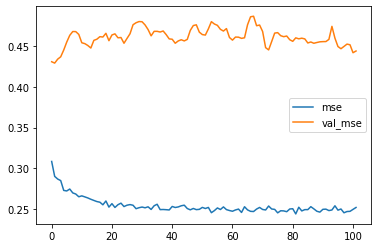

Prediction = 0.10091091692447662
Last corr = 0.973831
pred_col_name fun_rcl_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

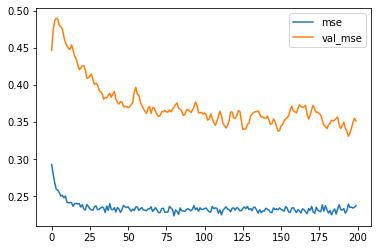

Prediction = 0.39685288071632385
Last corr = 0.880009
pred_col_name rop_peg_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

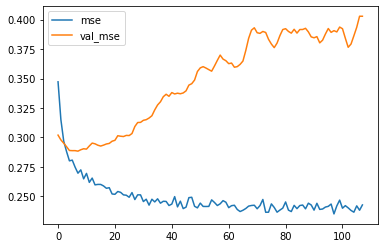

Prediction = 0.15553194284439087
Last corr = 0.51166
pred_col_name rop_mcri_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

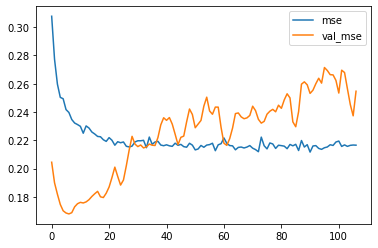

Prediction = 0.24329787492752075
Last corr = 0.739657
pred_col_name rop_bac_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

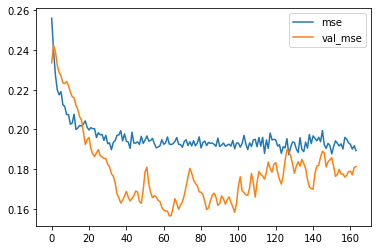

Prediction = 0.37558528780937195
Last corr = 0.774964
pred_col_name rop_seas_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a

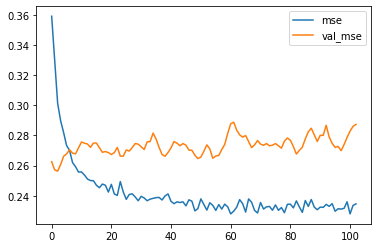

Prediction = 0.3093176484107971
Last corr = 0.758015
pred_col_name rop_ni_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b

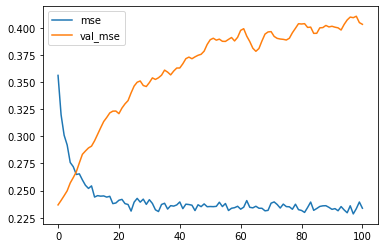

Prediction = 0.455339252948761
Last corr = 0.593797
pred_col_name rop_chdn_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

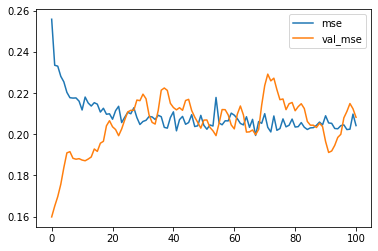

Prediction = 0.4665790796279907
Last corr = 0.734295
pred_col_name rop_six_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

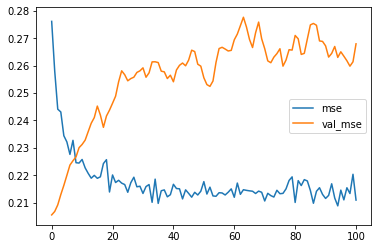

Prediction = 0.4467206299304962
Last corr = 0.651336
pred_col_name rop_pnr_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

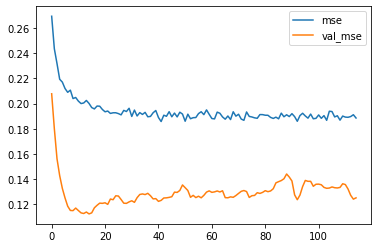

Prediction = 0.5397142767906189
Last corr = 0.743301
pred_col_name rop_ph_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36b

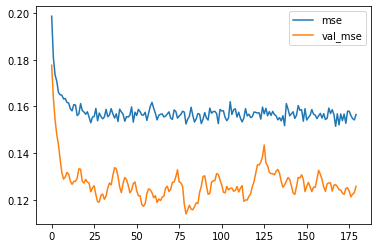

Prediction = 0.5381540060043335
Last corr = 0.718529
pred_col_name rop_ual_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

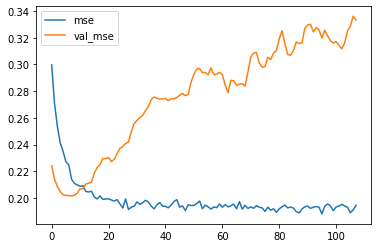

Prediction = 0.35307377576828003
Last corr = 0.692123
pred_col_name rop_vno_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

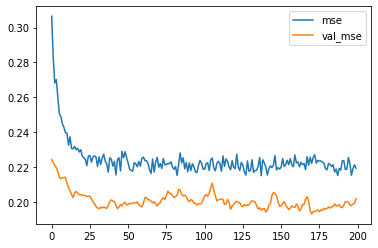

Prediction = 0.22614291310310364
Last corr = 0.00263
pred_col_name rop_penn_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

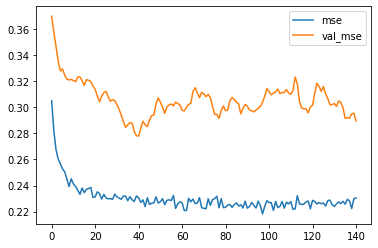

Prediction = 0.23770593106746674
Last corr = 0.681379
pred_col_name rop_so_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a36

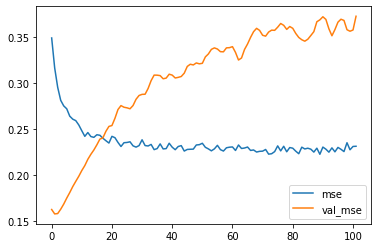

Prediction = 0.32248106598854065
Last corr = 0.35171
pred_col_name rop_znga_close_corr_rolling_7_days
n_sequences 1438
Training idx start at 0
Pct finished = 0.06954102920723226
Pct finished = 0.13908205841446453
Pct finished = 0.2086230876216968
Pct finished = 0.27816411682892905
Pct finished = 0.3477051460361613
Pct finished = 0.4172461752433936
Pct finished = 0.48678720445062584
Pct finished = 0.5563282336578581
Pct finished = 0.6258692628650904
Pct finished = 0.6954102920723226
Pct finished = 0.7649513212795549
Pct finished = 0.8344923504867872
Pct finished = 0.9040333796940194
Training idx end at 1379
Total idx checked 1439
Val idx start at 1380
Pct finished for val sequences = 0.9735744089012517
Val idx end at 1439
X val shape (45, 14, 4440)
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1634ecd68> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x24dd94b00> False
<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x16a3

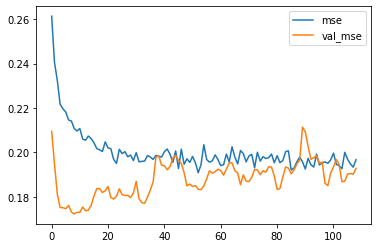

Prediction = 0.22984281182289124
Last corr = 0.615584
Predictions took 1.2538929184277852 mins


In [243]:
# 6.5 minutes for 10 stocks
final_stock_df = final_stock_df.dropna()
# test 14 day period instead of 30
# no dice
# test smaller network smae LR
# no dice
# test since 2016 data
# no dice
# test smaller learning rate 
# no dice
# test smaller batch size
# nothing
# test batch size  


# so the solution was less validation data

# wal_cwbc is turns out needed less training data

# test a new model for each pair, 200 epochs per . 2 minutes per 200 epochs
# 300 pairs take 10 hours sequentially
# X,y, X_val, y_val, scalers, pca_scalers 
prediction_for_upcoming_week(final_stock_df, pairs_of_stocks[:250], input_verbose=0)

In [ ]:
training_data

In [ ]:
np.isnan(X_val).sum()

In [1021]:
np.isnan(new_X_test).sum()

0